In [2]:
from importlib import reload
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from byc import standard_analysis as sa
from byc import database, plotting, files, utilities

In [1]:
from byc import database

Read in the data by selecting the master_index .csv for the experiment being analyzed. For this tutorial located at `...\byc_data\example_byc_expts\20200221_byc_analysis\20200221_byc_master_index.csv`

In [5]:
traces, filenames = sa.set_processed_traces(3, 10)

value is  0
cells_dfs is now 1 elements long
Checking senescence data for cell 0
sen_value is False
first_frame is 1
last_frame is 1
sen_distance_from_start is -1
Processing trace dataframe for cell 0 of 0


Have a look at the trace database to get a sense of what entries should look like

In [2]:
from byc import database
tracedb = database.byc_database
tracedb.trace_database_df.head()

,expt_name,trace_path,chase_index,bud_roi_path,trace_relpath,date
0,20191106_byc_by4741_young_NS,C:\Users\John Cooper\Projects\byc\data\2019110...,5,NaN,20191106_byc\analysis\20191106_byc_by4741_youn...,20191106
1,20191106_byc_by4741_young_NS,C:\Users\John Cooper\Projects\byc\data\2019110...,5,NaN,20191106_byc\analysis\20191106_byc_by4741_youn...,20191106
2,20191106_byc_by4741_young_NS,C:\Users\John Cooper\Projects\byc\data\2019110...,5,NaN,20191106_byc\analysis\20191106_byc_by4741_youn...,20191106
3,20191106_byc_by4741_young_NS,C:\Users\John Cooper\Projects\byc\data\2019110...,5,NaN,20191106_byc\analysis\20191106_byc_by4741_youn...,20191106
4,20191106_byc_by4741_young_NS,C:\Users\John Cooper\Projects\byc\data\2019110...,5,NaN,20191106_byc\analysis\20191106_byc_by4741_youn...,20191106


Create an experiment name to use when adding this experiment to the byc trace database

In [17]:
expt_name = "20200221_byc_JC069_rpn4d"

Add this experiment to trace database

In [9]:
tracedb.add_expt_to_trace_database(filenames, expt_name, chase_index=np.NaN, date='20200221')

Have a look at what you just added

In [18]:
tracedb.trace_database_df.set_index('expt_name').loc[expt_name, :]

trace_path      C:\Users\John Cooper\Box Sync\Finkelstein-Mato...
chase_index                                                   NaN
bud_roi_path                                                  NaN
Name: 20200221_byc_JC069_rpn4d, dtype: object

Read experiment trace dataframes in using database

In [19]:
cell_dfs = tracedb.get_cell_trace_dfs(expt_name)

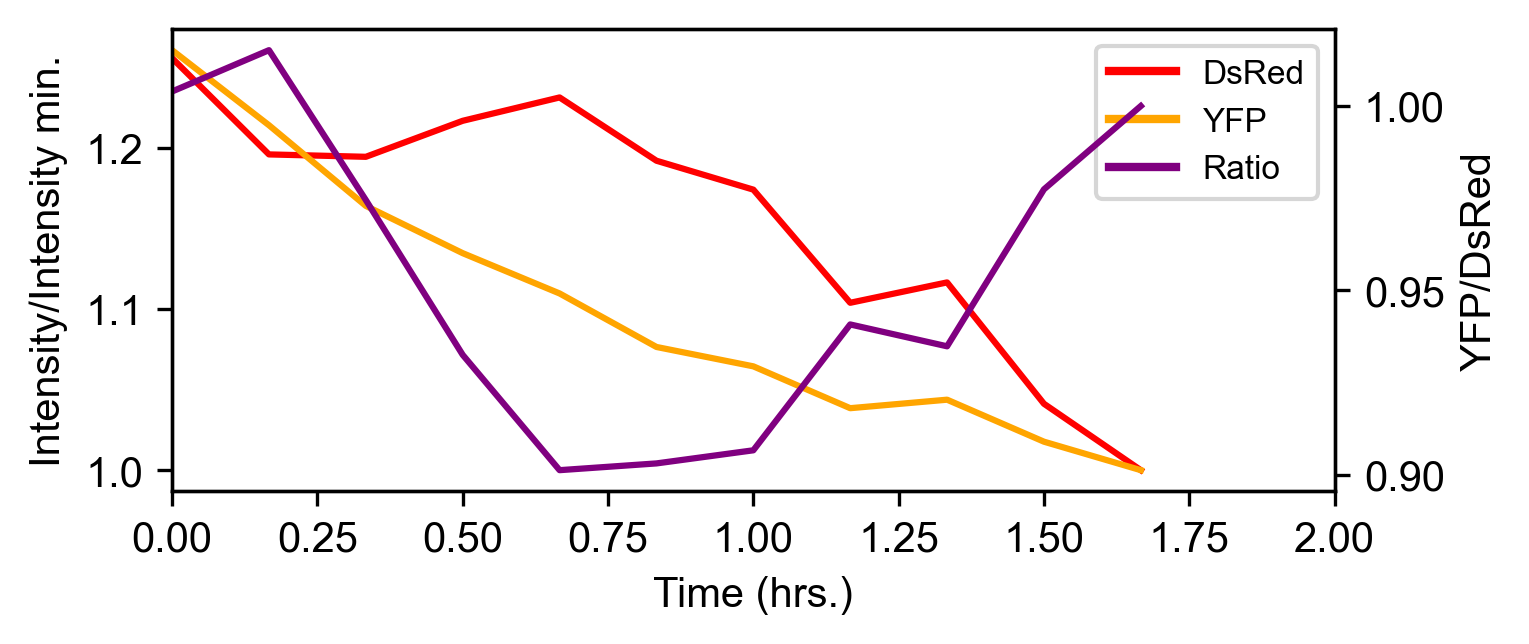

In [22]:
fig = plt.figure(figsize=(5, 2))
fig.set_dpi(300)

df = cell_dfs[0]
ax = plt.axes()

yfp_norm = df.yfp_mean/df.yfp_mean.min()
dsred_norm = df.dsred_mean/df.dsred_mean.min()

ax.set_ylabel("Intensity/Intensity min.")
ax.set_xlabel("Time (hrs.)")

ax.set_xlim(0, 2)
#ax.set_ylim(1, 1.8)

ax.plot(df.hours, dsred_norm, color='red')
ax.plot(df.hours, yfp_norm, color='orange')

ax2 = ax.twinx()
ax2.set_ylabel("YFP/DsRed")

ax2.plot(df.hours, yfp_norm/dsred_norm, color='purple')

custom_lines = [Line2D([0], [0], color='red', lw=2),
                Line2D([0], [0], color='orange', lw=2),
                Line2D([0], [0], color='purple', lw=2)]

ax.legend(custom_lines, ['DsRed',
                         'YFP',
                         'Ratio'], fontsize=8)

plt.show()

### 20201127_byc

In [1]:
import os
from importlib import reload
import re

import numpy as np
import pandas as pd
from skimage.draw import line
from skimage import io
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('default')
matplotlib.rcParams['font.sans-serif'] = 'Arial'
import seaborn as sns

from read_roi import read_roi_zip

from byc import files, utilities, constants
from byc.imagejpc import addcellroi
import byc.standard_analysis as sa

for mod in [files, addcellroi, constants, utilities, sa]:
    reload(mod)

### Creating a master index using crop_roi_dfs made by imagejpc/save_cell_roi_set.py

In [108]:
# Create a master index data frame for the purpose
# of running byc/bin/run_segmentation to crop and
# Otsu threshold based on crop ROIs
write = True
compartment_dir = r"C:\Users\John Cooper\Projects\byc\data\20201127_byc\pJC189_mScarletI-1013deg"
exptdir = os.path.dirname(compartment_dir)
pattern = constants.patterns.crop_roi_df_file
paths = utilities.get_filepaths_with_pattern(pattern,
                                             rootdir=exptdir)
bud_paths = utilities.get_filepaths_with_pattern(constants.patterns.bud_roi_df_file,
                                                 rootdir=exptdir)

dfs = [pd.read_csv(p) for p in paths]
mdf = pd.concat(dfs, ignore_index=True)
exptdir = os.path.dirname(mdf.compartment_dir.unique()[0])
# Manual fix. crop_roi_dfs were created when
# save cell roi set still defaulted to 'dsred'
mdf.loc[:, 'channels_collected'] = 'bf yfp rfp'
# Merge bud data into master index
budfs = [pd.read_csv(p) for p in bud_paths]
bud_mdf = pd.concat(budfs)
bud_mdf = bud_mdf.set_index(['xy', 'cell_index'])
mdf = mdf.set_index(['xy', 'cell_index'])
starting_cols = mdf.columns
for ind in bud_mdf.index:
    if ind in mdf.index:
        for col in bud_mdf.columns:
            if col not in starting_cols:
                mdf.loc[ind, col] = bud_mdf.loc[ind, col]
                
mdf.reset_index(inplace=True)
# mdf_path = utilities.get_all_master_index_paths(exptdir)[0]
mdf_path = os.path.join(exptdir, '20201127_master_index_analysis.csv')
if write:
    # Save the updated master_index
    mdf.to_csv(mdf_path, index=False)

In [8]:
compartment_dir = r"C:\Users\John Cooper\Projects\byc\data\20201127_byc\pJC189_mScarletI-1013deg"
exptdir = os.path.dirname(compartment_dir)
mdf_path = os.path.join(exptdir, '20201127_master_index_analysis.csv')
mdf = pd.read_csv(mdf_path)

In [10]:
bycds = sa.bycDataSet(mdf=mdf)
alldfs = bycds.cell_trace_dfs

Found data for cell 0 at C:\Users\John Cooper\Projects\byc\data\20201127_byc\pJC189_mScarletI-1013deg\20201127_byc_xy00_cell000_rfp_stack.csv
Looking for crop ROIs at C:\Users\John Cooper\Projects\byc\data\20201127_byc\pJC189_mScarletI-1013deg\20201127_byc_cell000_crop_rois.zip
Found data for cell 0 at C:\Users\John Cooper\Projects\byc\data\20201127_byc\pJC189_mScarletI-1013deg\20201127_byc_xy00_cell000_yfp_stack.csv
Looking for crop ROIs at C:\Users\John Cooper\Projects\byc\data\20201127_byc\pJC189_mScarletI-1013deg\20201127_byc_cell000_crop_rois.zip
Found data for cell 1 at C:\Users\John Cooper\Projects\byc\data\20201127_byc\pJC189_mScarletI-1013deg\20201127_byc_xy00_cell001_rfp_stack.csv
Looking for crop ROIs at C:\Users\John Cooper\Projects\byc\data\20201127_byc\pJC189_mScarletI-1013deg\20201127_byc_cell001_crop_rois.zip
Found data for cell 1 at C:\Users\John Cooper\Projects\byc\data\20201127_byc\pJC189_mScarletI-1013deg\20201127_byc_xy00_cell001_yfp_stack.csv
Looking for crop ROIs

Looking for crop ROIs at C:\Users\John Cooper\Projects\byc\data\20201127_byc\pJC197_NLS-mScarletI\20201127_byc_cell004_crop_rois.zip
Found data for cell 22 at C:\Users\John Cooper\Projects\byc\data\20201127_byc\pJC197_NLS-mScarletI\20201127_byc_xy05_cell004_yfp_stack.csv
Looking for crop ROIs at C:\Users\John Cooper\Projects\byc\data\20201127_byc\pJC197_NLS-mScarletI\20201127_byc_cell004_crop_rois.zip
Found data for cell 23 at C:\Users\John Cooper\Projects\byc\data\20201127_byc\pJC197_NLS-mScarletI\20201127_byc_xy05_cell005_rfp_stack.csv
Looking for crop ROIs at C:\Users\John Cooper\Projects\byc\data\20201127_byc\pJC197_NLS-mScarletI\20201127_byc_cell005_crop_rois.zip
Found data for cell 23 at C:\Users\John Cooper\Projects\byc\data\20201127_byc\pJC197_NLS-mScarletI\20201127_byc_xy05_cell005_yfp_stack.csv
Looking for crop ROIs at C:\Users\John Cooper\Projects\byc\data\20201127_byc\pJC197_NLS-mScarletI\20201127_byc_cell005_crop_rois.zip
Found data for cell 24 at C:\Users\John Cooper\Proj

In [11]:
df = pd.concat(alldfs, ignore_index=True)
df = df.sort_values(by='total_hours')

### Plots with YFP and RFP

In [12]:
colors = sns.color_palette("hls", 10)
green = colors[3]
red = colors[0]

Single axis

y_var range:  856.537
y_var2 range:  1534.8460000000002
Warning! Defaulting to collection interval of 10 minutes
C:\Users\John Cooper\Projects\byc\data\20201127_byc\pJC197_NLS-mScarletI\20201127_byc_cell004_bud_rois.zip
y_var range:  698.3050000000001
y_var2 range:  1569.9279999999999
Warning! Defaulting to collection interval of 10 minutes
C:\Users\John Cooper\Projects\byc\data\20201127_byc\pJC197_NLS-mScarletI\20201127_byc_cell002_bud_rois.zip
y_var range:  852.214
y_var2 range:  1978.056
Warning! Defaulting to collection interval of 10 minutes
C:\Users\John Cooper\Projects\byc\data\20201127_byc\pJC197_NLS-mScarletI\20201127_byc_cell007_bud_rois.zip
y_var range:  679.5520000000001
y_var2 range:  1649.194
Warning! Defaulting to collection interval of 10 minutes
C:\Users\John Cooper\Projects\byc\data\20201127_byc\pJC197_NLS-mScarletI\20201127_byc_cell000_bud_rois.zip
y_var range:  822.9399999999998
y_var2 range:  2125.0099999999998
Warning! Defaulting to collection interval of 10 minut

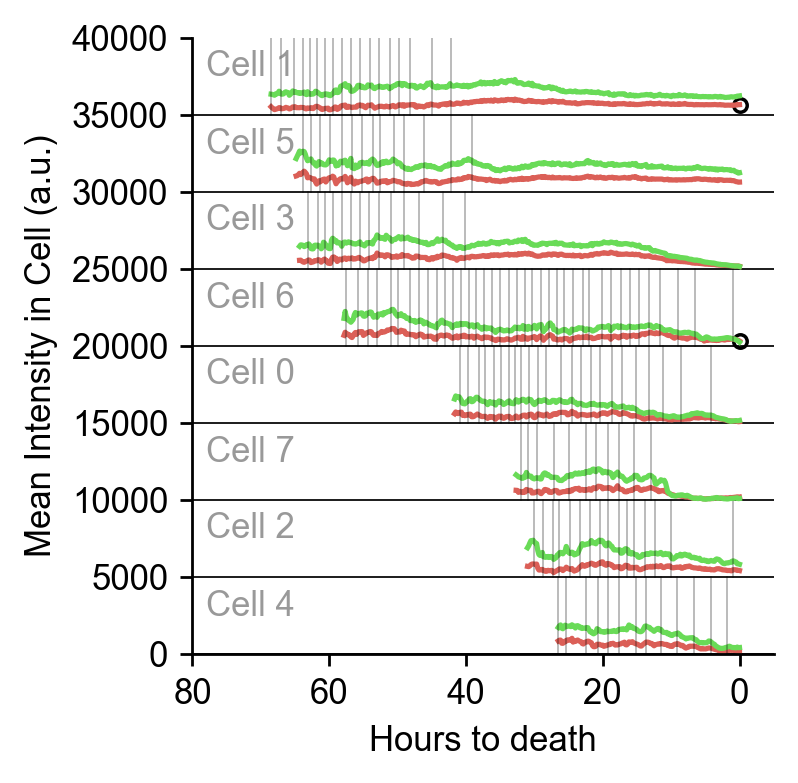

In [16]:
plasmid_name = 'pJC197'
subdf = df.loc[df.plasmid == plasmid_name]
# subdf = subdf[subdf.end_event_type=='death']
y_var = 'Mean_rfp'
y_var2 = 'Mean_yfp'
dfs = [subdf.loc[subdf.cell_index==i, :].sort_values(by='hours') for i in subdf.cell_index.unique()]
mins = np.array([celldf.loc[:, y_var].min() for celldf in dfs])
mins2 = np.array([celldf.loc[:, y_var2].min() for celldf in dfs])
bg = np.median(mins)
bg = 800
bg2 = 500
offset_step = 5000
y_ul = offset_step*len(dfs)
x_ul = 80
fig = plt.figure(figsize=(3, 0.4*len(dfs)))
fig.set_dpi(250)
colors = sns.color_palette("hls", len(dfs))
ax = plt.axes()
ax.set_xlim(x_ul, -5)
ax.set_ylim(0, y_ul)
ax.set_yticks(np.arange(0, y_ul+1, offset_step))
ax.set_ylabel('Mean Intensity in Cell (a.u.)')
ax.set_xlabel('Hours to death')

y_var = 'Mean_rfp'
for i, celldf in enumerate(dfs):
    print('y_var range: ', celldf[y_var].max() - celldf[y_var].min())
    print('y_var2 range: ', celldf[y_var2].max() - celldf[y_var2].min())
    offset = offset_step*i
    cell_index = celldf.cell_index.iloc[0]
    ax.text(x_ul-2, offset + 0.5*offset_step, f'Cell {cell_index}',
            fontsize=10, color='gray', alpha=0.8)
    ax.axhline(offset, linewidth=0.5, color='black')
      
    y = celldf[y_var] + offset - bg
    y2 = celldf[y_var2] + offset - bg2
    if True in celldf.hours_to_death.isna().values:
        x = celldf.hours.max() - celldf.hours
        ax.scatter(x[x.index[-1]], y[y.index[-1]],
                   facecolor='white', edgecolor='black', linewidth=1, s=15)
#         print(f"No hours to death for cell {cell_index}. \nFinal frame is end of expt")
    else:
        x = celldf.hours_to_death
    ax.plot(x, y,
            color=red, linewidth=1.5)
    ax.plot(x, y2,
            color=green, linewidth=1.5)
    
    # Annotate bud appearance hours
    bud_hours_to_death = sa.get_bud_hours(celldf=celldf, reference='death')
    for hour in bud_hours_to_death:
        x = hour
        ymin = offset_step*(i)
        ymin = ymin/(len(dfs)*offset_step)
        ymax = offset_step*(i+1)
        ymax = ymax/(len(dfs)*offset_step)
        ax.axvline(x=x, ymin=ymin, ymax=ymax,
                   color='black', alpha=0.3, linewidth=0.5)

      
names = ['top', 'right']

for spine in [ax.spines[n] for n in names]:
    spine.set_visible(False)
    
fig.savefig(os.path.join(exptdir, f'{plasmid_name}.svg'))

# 20201223_byc

In [1]:
import os
from importlib import reload
import re

import numpy as np
import pandas as pd
from skimage.draw import line
from skimage import io
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('default')
matplotlib.rcParams['font.sans-serif'] = 'Arial'
import seaborn as sns

from read_roi import read_roi_zip

from byc import files, utilities, constants
from byc.imagejpc import addcellroi
import byc.standard_analysis as sa

for mod in [files, addcellroi, constants, utilities, sa]:
    reload(mod)

In [15]:
# Create master index for running byc/bin/run_segmentation.py
df_paths = files.select_files("Choose .csvs")

In [16]:
dfs = [pd.read_csv(path) for path in df_paths]
mdf = pd.concat(dfs, ignore_index=True)
compartment_dir = os.path.dirname(df_paths[0])
write_path = os.path.join(compartment_dir, '20201223_byc_pJC184_rpn4d_young_chase_master_index.csv')
mdf.to_csv(write_path, index=False)

In [8]:
mdf

,cell_index,expt_type,channels_collected,compartment_dir,compartment_reldir,active_imp_path,crop_roi_set_path,end_event_type,xy,date,crop_active_imp_relpath,crop_roi_set_relpath
0,0,byc,bf yfp rfp,C:\Users\John Cooper\Projects\byc\data\2020122...,20201223_byc\20201223_byc_pJC184_BY4741_young_...,C:\Users\John Cooper\Projects\byc\data\2020122...,C:\Users\John Cooper\Projects\byc\data\2020122...,death,3,20201223,20201223_byc\20201223_byc_pJC184_BY4741_young_...,20201223_byc\20201223_byc_pJC184_BY4741_young_...
1,1,byc,bf yfp rfp,C:\Users\John Cooper\Projects\byc\data\2020122...,20201223_byc\20201223_byc_pJC184_BY4741_young_...,C:\Users\John Cooper\Projects\byc\data\2020122...,C:\Users\John Cooper\Projects\byc\data\2020122...,death,3,20201223,20201223_byc\20201223_byc_pJC184_BY4741_young_...,20201223_byc\20201223_byc_pJC184_BY4741_young_...
2,2,byc,bf yfp rfp,C:\Users\John Cooper\Projects\byc\data\2020122...,20201223_byc\20201223_byc_pJC184_BY4741_young_...,C:\Users\John Cooper\Projects\byc\data\2020122...,C:\Users\John Cooper\Projects\byc\data\2020122...,sen,3,20201223,20201223_byc\20201223_byc_pJC184_BY4741_young_...,20201223_byc\20201223_byc_pJC184_BY4741_young_...
3,3,byc,bf yfp rfp,C:\Users\John Cooper\Projects\byc\data\2020122...,20201223_byc\20201223_byc_pJC184_BY4741_young_...,C:\Users\John Cooper\Projects\byc\data\2020122...,C:\Users\John Cooper\Projects\byc\data\2020122...,death,3,20201223,20201223_byc\20201223_byc_pJC184_BY4741_young_...,20201223_byc\20201223_byc_pJC184_BY4741_young_...
4,4,byc,bf yfp rfp,C:\Users\John Cooper\Projects\byc\data\2020122...,20201223_byc\20201223_byc_pJC184_BY4741_young_...,C:\Users\John Cooper\Projects\byc\data\2020122...,C:\Users\John Cooper\Projects\byc\data\2020122...,death,3,20201223,20201223_byc\20201223_byc_pJC184_BY4741_young_...,20201223_byc\20201223_byc_pJC184_BY4741_young_...
5,5,byc,bf yfp rfp,C:\Users\John Cooper\Projects\byc\data\2020122...,20201223_byc\20201223_byc_pJC184_BY4741_young_...,C:\Users\John Cooper\Projects\byc\data\2020122...,C:\Users\John Cooper\Projects\byc\data\2020122...,death,3,20201223,20201223_byc\20201223_byc_pJC184_BY4741_young_...,20201223_byc\20201223_byc_pJC184_BY4741_young_...
6,6,byc,bf yfp rfp,C:\Users\John Cooper\Projects\byc\data\2020122...,20201223_byc\20201223_byc_pJC184_BY4741_young_...,C:\Users\John Cooper\Projects\byc\data\2020122...,C:\Users\John Cooper\Projects\byc\data\2020122...,sen,3,20201223,20201223_byc\20201223_byc_pJC184_BY4741_young_...,20201223_byc\20201223_byc_pJC184_BY4741_young_...


In [ ]:
# Create a master index data frame for the purpose
# of running byc/bin/run_segmentation to crop and
# Otsu threshold based on crop ROIs
write = True
compartment_dir = r"C:\Users\John Cooper\Projects\byc\data\20201223_byc\20201223_byc_pJC184_BY4741_young_chase\cropped"
exptdir = os.path.dirname(compartment_dir)
pattern = constants.patterns.crop_roi_df_file
paths = utilities.get_filepaths_with_pattern(pattern,
                                             rootdir=exptdir)
bud_paths = utilities.get_filepaths_with_pattern(constants.patterns.bud_roi_df_file,
                                                 rootdir=exptdir)

dfs = [pd.read_csv(p) for p in paths]
mdf = pd.concat(dfs, ignore_index=True)
exptdir = os.path.dirname(mdf.compartment_dir.unique()[0])
# Manual fix. crop_roi_dfs were created when
# save cell roi set still defaulted to 'dsred'
mdf.loc[:, 'channels_collected'] = 'bf yfp rfp'
# Merge bud data into master index
budfs = [pd.read_csv(p) for p in bud_paths]
bud_mdf = pd.concat(budfs)
bud_mdf = bud_mdf.set_index(['xy', 'cell_index'])
mdf = mdf.set_index(['xy', 'cell_index'])
starting_cols = mdf.columns
for ind in bud_mdf.index:
    if ind in mdf.index:
        for col in bud_mdf.columns:
            if col not in starting_cols:
                mdf.loc[ind, col] = bud_mdf.loc[ind, col]
                
mdf.reset_index(inplace=True)
# mdf_path = utilities.get_all_master_index_paths(exptdir)[0]
mdf_path = os.path.join(exptdir, '20201127_master_index_analysis.csv')
if write:
    # Save the updated master_index
    mdf.to_csv(mdf_path, index=False)

# 20210126_byc - Young pJC184 250 &mu;M Tet chase in BY4741, rpn4&Delta;

In [4]:
import os
import shutil

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

plt.style.use('default')
matplotlib.rcParams['font.sans-serif'] = 'Arial'

from byc import standard_analysis as sa
from byc import files
import byc.fitting_tools as ft

In [5]:
from importlib import reload
reload(sa)

<module 'byc.standard_analysis' from 'C:\\Users\\John Cooper\\Projects\\byc\\byc\\standard_analysis.py'>

### 1. Create master df from .csvs generated by running the Fiji plugin `imagejpc/save cell roi set` and entering 'crop' as roi type

In [14]:
# Create master index for running byc/bin/run_segmentation.py
df_paths = files.select_files("Choose .csvs")
dfs = [pd.read_csv(path) for path in df_paths]
mdf = pd.concat(dfs, ignore_index=True)
compartment_dir = os.path.dirname(df_paths[0])
write_path = os.path.join(compartment_dir, '20210126_byc_pJC184_BY4741_young_chase_master_index.csv')
mdf.to_csv(write_path, index=False)
WT_mdf = pd.read_csv(write_path)

In [15]:
# Create master index for running byc/bin/run_segmentation.py
df_paths = files.select_files("Choose .csvs")
dfs = [pd.read_csv(path) for path in df_paths]
mdf = pd.concat(dfs, ignore_index=True)
compartment_dir = os.path.dirname(df_paths[0])
write_path = os.path.join(compartment_dir, '20210126_byc_pJC184_rpn4d_young_chase_master_index.csv')
mdf.to_csv(write_path, index=False)
rpn4d_mdf = pd.read_csv(write_path)

### 2. After creating master index, run `byc/bin/run_segmentation` and when prompted select the master index file created above

### 3. Use Fiji to curate cell outlines created in `run_segmentation`

    A.) Open the cropped cell stacks (all channels as well as the otsu_thresholded one)
    B.) Make the otsu thresholded stack the active image. Press 'g' to convert the stack to a mask (cell area should be black after this).
    C.) Press '8' to run a watershed on the stack (find edges between overlapping/adjacent blobs)
    D.) Press 'q' to set measurements. Choose desired measurements (more the better). Choose None for redirect image
    E.) Press 'u' to run 'Analyze Particles'. At 60x, set Size range to 100-1000 square pixels and circularity to 0.8-1. Check 'Add to manager' and 'Exclude on edges. 'Click 'OK'
    F.) In ROI manager, delete or redraw bad ROIs. Add new ones so that there are at least one for the first and last frames and a every 10-20 frames, then run `imagejpc/save cell roi set` and select 'measurement' as ROI type

### 4. To quantify cell fluorescence traces using the ROIs above, , run `imagejpc/measure rois` with the cell's cropped channel stacks and measurement_rois.zip files open

### 5. Read in traces

In [49]:
WT_mdf_path = r"C:\Users\John Cooper\Projects\byc\data\20210126_byc\20210126_byc_pJC184_BY4741_young_chase_master_index.csv"
WT_mdf = pd.read_csv(WT_mdf_path)
rpn4d_mdf_path = r"C:\Users\John Cooper\Projects\byc\data\20210126_byc\20210126_byc_pJC184_rpn4d_young_chase_master_index.csv"
rpn4d_mdf = pd.read_csv(rpn4d_mdf_path)

In [50]:
wt_ds = sa.bycDataSet(mdf=WT_mdf)
wt_trace_dfs = wt_ds.cell_trace_dfs

rpn4d_ds = sa.bycDataSet(mdf=rpn4d_mdf)
rpn4d_trace_dfs = rpn4d_ds.cell_trace_dfs

Found data for cell 0 at C:\Users\John Cooper\Projects\byc\data\20210126_byc\20210126_byc_pJC184_BY4741_young_chase\20210126_byc_xy00_cell000_bf_stack.csv
Looking for crop ROIs at C:\Users\John Cooper\Projects\byc\data\20210126_byc\20210126_byc_pJC184_BY4741_young_chase\20210126_byc_cell000_crop_rois.zip
Found data for cell 0 at C:\Users\John Cooper\Projects\byc\data\20210126_byc\20210126_byc_pJC184_BY4741_young_chase\20210126_byc_xy00_cell000_rfp_stack.csv
Looking for crop ROIs at C:\Users\John Cooper\Projects\byc\data\20210126_byc\20210126_byc_pJC184_BY4741_young_chase\20210126_byc_cell000_crop_rois.zip
Found data for cell 1 at C:\Users\John Cooper\Projects\byc\data\20210126_byc\20210126_byc_pJC184_BY4741_young_chase\20210126_byc_xy00_cell001_bf_stack.csv
Looking for crop ROIs at C:\Users\John Cooper\Projects\byc\data\20210126_byc\20210126_byc_pJC184_BY4741_young_chase\20210126_byc_cell001_crop_rois.zip
Found data for cell 1 at C:\Users\John Cooper\Projects\byc\data\20210126_byc\2021

Looking for crop ROIs at C:\Users\John Cooper\Projects\byc\data\20210126_byc\20210126_byc_pJC184_rpn4d_young_chase\20210126_byc_cell008_crop_rois.zip
Found data for cell 8 at C:\Users\John Cooper\Projects\byc\data\20210126_byc\20210126_byc_pJC184_rpn4d_young_chase\20210126_byc_xy03_cell008_rfp_stack.csv
Looking for crop ROIs at C:\Users\John Cooper\Projects\byc\data\20210126_byc\20210126_byc_pJC184_rpn4d_young_chase\20210126_byc_cell008_crop_rois.zip
Found data for cell 9 at C:\Users\John Cooper\Projects\byc\data\20210126_byc\20210126_byc_pJC184_rpn4d_young_chase\20210126_byc_xy03_cell009_bf_stack.csv
Looking for crop ROIs at C:\Users\John Cooper\Projects\byc\data\20210126_byc\20210126_byc_pJC184_rpn4d_young_chase\20210126_byc_cell009_crop_rois.zip
Found data for cell 9 at C:\Users\John Cooper\Projects\byc\data\20210126_byc\20210126_byc_pJC184_rpn4d_young_chase\20210126_byc_xy03_cell009_rfp_stack.csv
Looking for crop ROIs at C:\Users\John Cooper\Projects\byc\data\20210126_byc\20210126_

### 6. Find peak frames toward beginning of traces to identify when to start window of tet chase for fitting exponential decay

In [6]:
def find_chase_start_frame(trace_dfs, window, palette='Reds'):
    """
    Find the maximum "df.Mean_rfp" value within the frame_index 
    window range for each trace_df in trace_dfs, plot the results
    and return the mean of those maximum frames
    """
    traces_df = pd.concat(trace_dfs, ignore_index=True)
    
    # Setting up analysis
    index = ['cell_index']
    aggfunc = np.argmax
    table = pd.pivot_table(traces_df[traces_df.frame_index.isin(window)], index=index, aggfunc=aggfunc)
    # Plotting
    fig = plt.figure(figsize=(4, 3))
    fig.set_dpi(300)
    ax = plt.axes()
    palette = sns.color_palette(palette, n_colors=len(trace_dfs))
    for df in trace_dfs:
        i = df.cell_index.iloc[0]
        y = df['Mean_rfp']
        ax.plot(y, color=palette[i])
        peak_frame = table.Mean_rfp[i] + window[0]
        y_at_peak_frame = y[peak_frame]
        ax.scatter(peak_frame, y_at_peak_frame,
                   edgecolor=palette[i], facecolor='white')

    mean_max_frame = table.Mean_rfp.mean() + window[0]
    mean_max_frame = np.round(mean_max_frame, 1)
    ax.axvline(x=mean_max_frame, color='black', linewidth=1)
    ax.annotate(s=f'Mean peak frame = {mean_max_frame}', xy=(mean_max_frame + 4, 600))
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 800)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return mean_max_frame

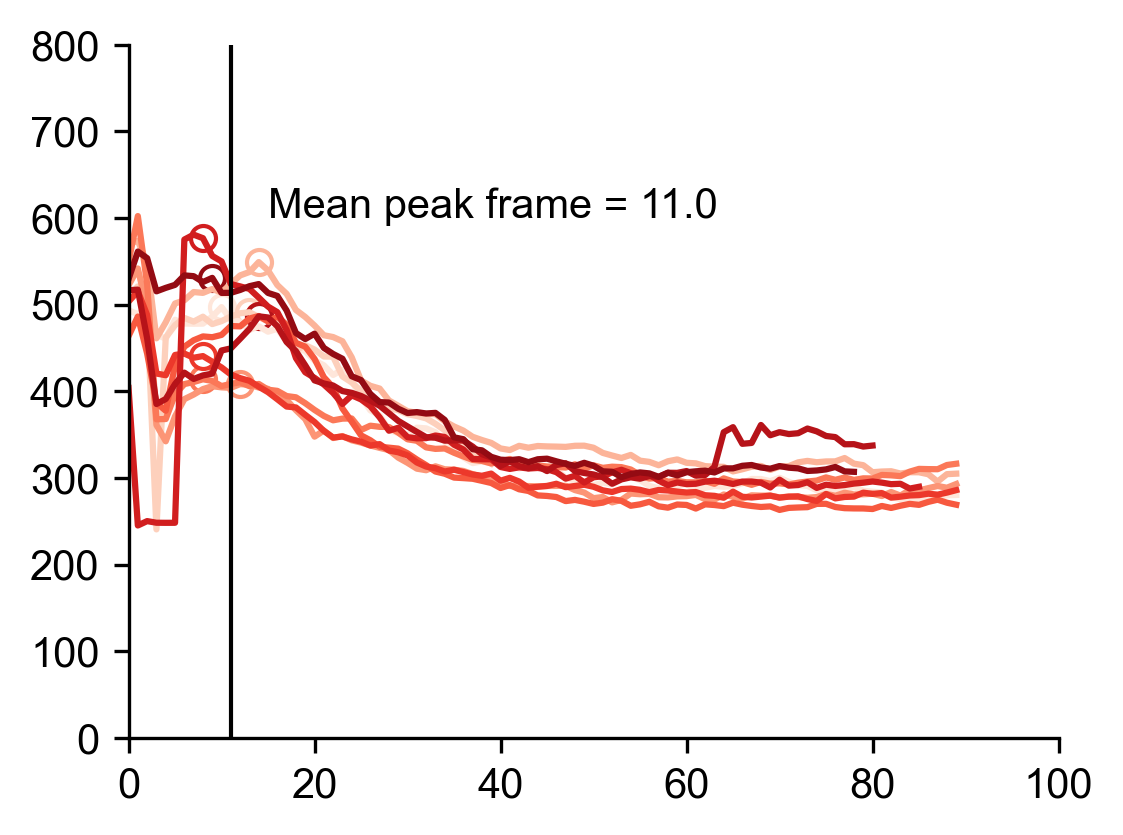

In [6]:
ind = find_chase_start_frame(rpn4d_trace_dfs, range(8, 40))

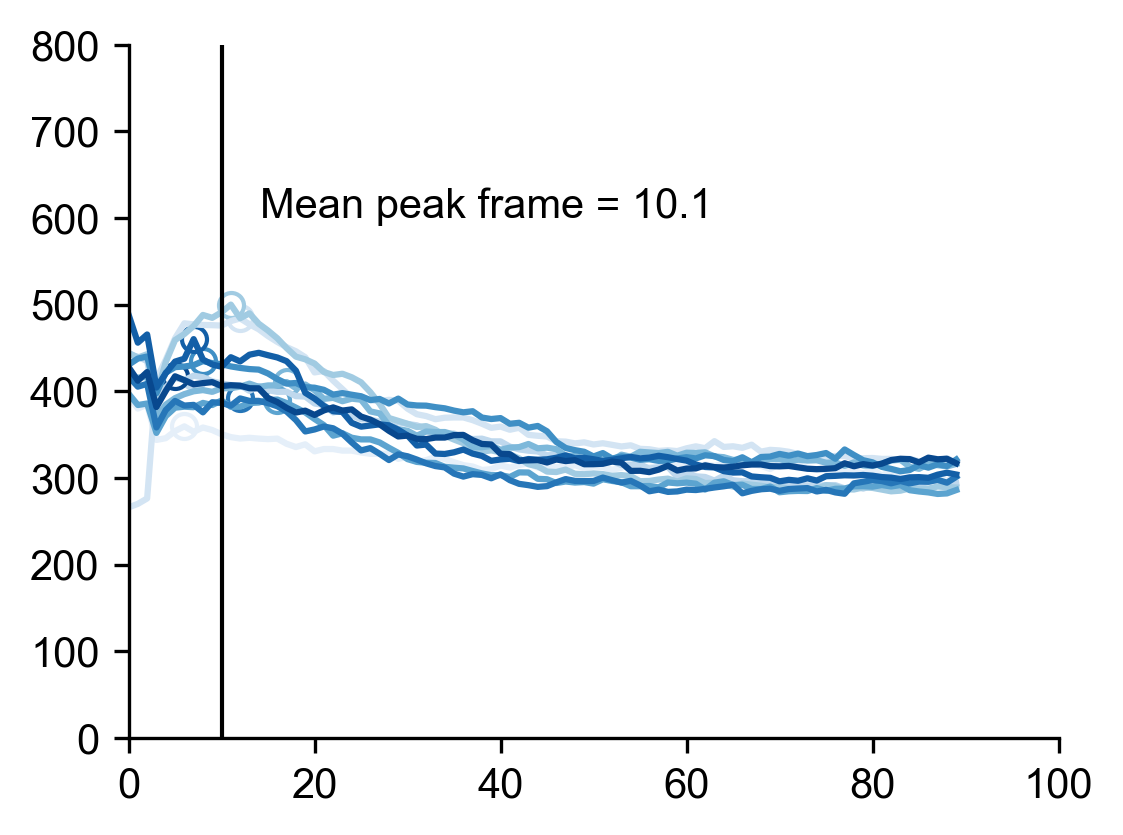

In [29]:
ind = find_chase_start_frame(wt_trace_dfs, range(3, 40), palette="Blues")

### 7. Plot chase window

Text(0.5, 0, 'Time after chase (hrs)')

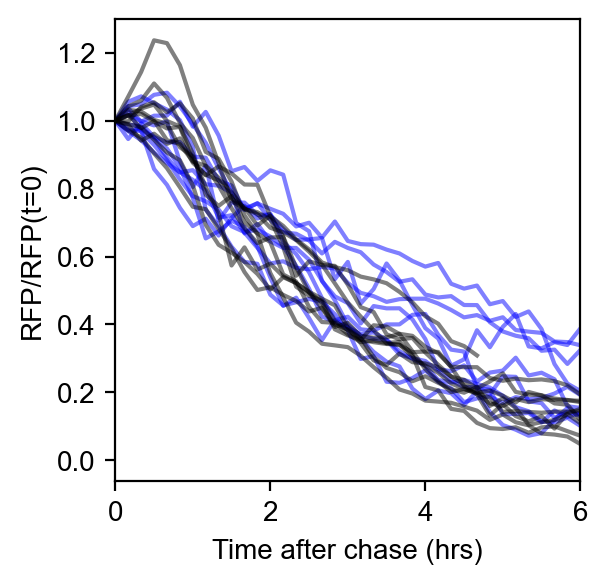

In [51]:
colors = ['blue', 'black']
chase_duration = 56

fig = plt.figure(figsize=(3, 3))
fig.set_dpi(200)
ax = plt.axes()

# Plot WT cells
dfs = wt_trace_dfs
chase_frame = 12
start_frame = chase_frame
offset = (start_frame*10)/60

for i, df in enumerate(dfs):
    df.loc[:, 'mean_rfp_bg_sub'] = df.Mean_rfp - df.Mean_rfp.min()
    df.loc[:, 'norm_rfp'] = df.mean_rfp_bg_sub/df.loc[chase_frame, 'mean_rfp_bg_sub']
    
    x = df.hours[start_frame:start_frame + chase_duration] - offset
    y = df.norm_rfp[start_frame:start_frame + chase_duration]
    ax.plot(x, y,
            color=colors[0], alpha=0.5)
    
# Plot rpn4d cells
dfs = rpn4d_trace_dfs
chase_frame = 11
start_frame = chase_frame
offset = (start_frame*10)/60

for i, df in enumerate(dfs):
    df.loc[:, 'mean_rfp_bg_sub'] = df.Mean_rfp - df.Mean_rfp.min()
    df.loc[:, 'norm_rfp'] = df.mean_rfp_bg_sub/df.loc[chase_frame, 'mean_rfp_bg_sub']
    
    x = df.hours[start_frame:start_frame + chase_duration] - offset
    y = df.norm_rfp[start_frame:start_frame + chase_duration]
    ax.plot(x, y,
            color=colors[1], alpha=0.5)
    
# ax.set_ylim(0, 1.2)
ax.set_xlim(0, 6)

ax.set_ylabel('RFP/RFP(t=0)')
ax.set_xlabel('Time after chase (hrs)')

In [52]:
from byc import fitting_tools as ft

wt_fits_df = ft.get_all_fits_df(wt_trace_dfs, 12, 38, col_name='Mean_rfp')
rpn4d_fits_df = ft.get_all_fits_df(rpn4d_trace_dfs, 11, 37, col_name='Mean_rfp')
wt_fits_df.loc[:, 'genotype'] = 'BY4741'
rpn4d_fits_df.loc[:, 'genotype'] = 'rpn4d'
all_fits_df = pd.concat([wt_fits_df, rpn4d_fits_df], ignore_index=True)
all_fits_table = pd.pivot_table(all_fits_df, index=['cell_index', 'genotype'], aggfunc=np.mean).reset_index()

Could not fit cell with cell_index=6
fit failed for cell 6


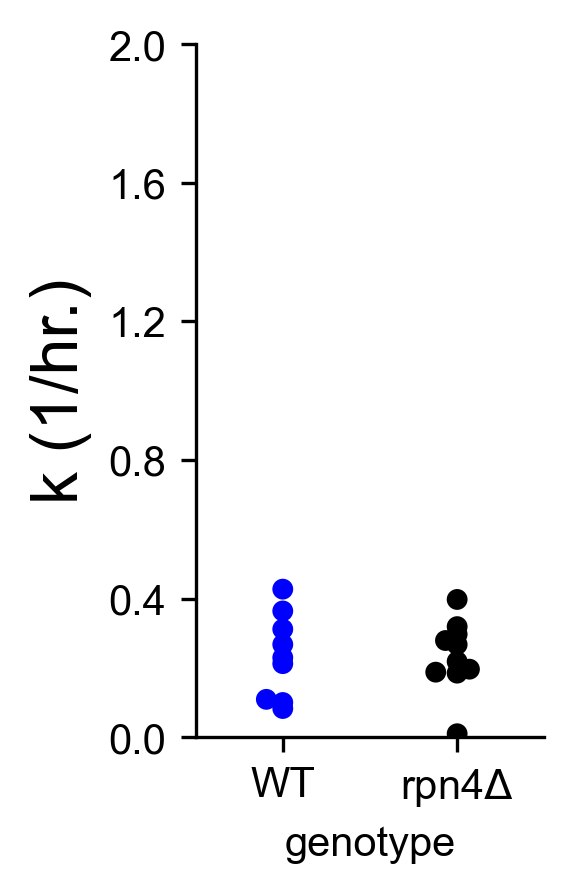

In [56]:
palette = sns.color_palette(['blue', 'black'])

fig = plt.figure(figsize=(1.5, 3))
fig.set_dpi(300)
ax = sns.swarmplot(x='genotype', y='b', data=all_fits_table,
                   palette=palette)
ax.set_ylim(0, 2)
ax.set_ylabel('k (1/hr.)', fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_yticks(np.arange(0, 2.1, 0.4))
ax.set_xticklabels(['WT', r'rpn4$\Delta$'])

fig.savefig('20210126_byc_pJC184_decay_in_BY4741_rpn4d.svg')

# 20210205_byc - Young pJC031 250 &mu;M Tet chase in BY4741, rpn4&Delta;

In [2]:
import os
import shutil

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

plt.style.use('default')
matplotlib.rcParams['font.sans-serif'] = 'Arial'

from byc import standard_analysis as sa
from byc import files
import byc.fitting_tools as ft

In [3]:
from importlib import reload
reload(sa)

<module 'byc.standard_analysis' from 'C:\\Users\\John Cooper\\Projects\\byc\\byc\\standard_analysis.py'>

### 1. Create master df from .csvs generated by running the Fiji plugin `imagejpc/save cell roi set` and selecting entering 'crop' as roi type

In [4]:
# Create master index for running byc/bin/run_segmentation.py
df_paths = files.select_files("Choose .csvs")
dfs = [pd.read_csv(path) for path in df_paths]
mdf = pd.concat(dfs, ignore_index=True)
compartment_dir = os.path.dirname(df_paths[0])
write_path = os.path.join(compartment_dir, '20210205_byc_pJC031_BY4741_young_chase_master_index.csv')
mdf.to_csv(write_path, index=False)
WT_mdf = pd.read_csv(write_path)

In [24]:
# Create master index for running byc/bin/run_segmentation.py
df_paths = files.select_files("Choose .csvs")
dfs = [pd.read_csv(path) for path in df_paths]
mdf = pd.concat(dfs, ignore_index=True)
compartment_dir = os.path.dirname(df_paths[0])
write_path = os.path.join(compartment_dir, '20210205_byc_pJC031_rpn4d_young_chase_master_index.csv')
mdf.to_csv(write_path, index=False)
rpn4d_mdf = pd.read_csv(write_path)

### 2. After creating master index, run `byc/bin/run_segmentation` and when prompted select the master index file created above

### 3. Use Fiji to curate cell outlines created in `run_segmentation`

    A.) Open the cropped cell stacks (all channels as well as the otsu_thresholded one)
    B.) Make the otsu thresholded stack the active image. Press 'g' to convert the stack to a mask (cell area should be black after this).
    C.) Press '8' to run a watershed on the stack (find edges between overlapping/adjacent blobs)
    D.) Press 'q' to set measurements. Choose desired measurements (more the better). Choose None for redirect image
    E.) Press 'u' to run 'Analyze Particles'. At 60x, set Size range to 100-1000 square pixels and circularity to 0.8-1. Check 'Add to manager' and 'Exclude on edges. 'Click 'OK'
    F.) In ROI manager, delete or redraw bad ROIs. Add new ones so that there are at least one for the first and last frames and a every 10-20 frames, then run `imagejpc/save cell roi set` and select 'measurement' as ROI type

### 4. To quantify cell fluorescence traces using the ROIs above, , run `imagejpc/measure rois` with the cell's cropped channel stacks and measurement_rois.zip files open

### 5. Read in traces

In [5]:
WT_mdf_path = r"C:\Users\John Cooper\Projects\byc\data\20210205_byc\20210205_byc_pJC031_BY4741_young_chase_master_index.csv"
WT_mdf = pd.read_csv(WT_mdf_path)
rpn4d_mdf_path = r"C:\Users\John Cooper\Projects\byc\data\20210205_byc\20210205_byc_pJC031_rpn4d_young_chase_master_index.csv"
rpn4d_mdf = pd.read_csv(rpn4d_mdf_path)

In [6]:
wt_ds = sa.bycDataSet(mdf=WT_mdf)
wt_trace_dfs = wt_ds.cell_trace_dfs

rpn4d_ds = sa.bycDataSet(mdf=rpn4d_mdf)
rpn4d_trace_dfs = rpn4d_ds.cell_trace_dfs

Found data for cell 0 at C:\Users\John Cooper\Projects\byc\data\20210205_byc\20210205_byc_pJC031_BY4741_young_chase\20210205_byc_xy00_cell000_bf_stack.csv
Looking for crop ROIs at C:\Users\John Cooper\Projects\byc\data\20210205_byc\20210205_byc_pJC031_BY4741_young_chase\20210205_byc_cell000_crop_rois.zip
Found data for cell 0 at C:\Users\John Cooper\Projects\byc\data\20210205_byc\20210205_byc_pJC031_BY4741_young_chase\20210205_byc_xy00_cell000_rfp_stack.csv
Looking for crop ROIs at C:\Users\John Cooper\Projects\byc\data\20210205_byc\20210205_byc_pJC031_BY4741_young_chase\20210205_byc_cell000_crop_rois.zip
Found data for cell 0 at C:\Users\John Cooper\Projects\byc\data\20210205_byc\20210205_byc_pJC031_BY4741_young_chase\20210205_byc_xy00_cell000_yfp_stack.csv
Looking for crop ROIs at C:\Users\John Cooper\Projects\byc\data\20210205_byc\20210205_byc_pJC031_BY4741_young_chase\20210205_byc_cell000_crop_rois.zip
Found data for cell 1 at C:\Users\John Cooper\Projects\byc\data\20210205_byc\202

### 6. Find peak frames toward beginning of traces to identify when to start window of tet chase for fitting exponential decay

In [7]:
def find_chase_start_frame(trace_dfs, window, palette='Reds'):
    """
    Find the maximum "df.Mean_rfp" value within the frame_index 
    window range for each trace_df in trace_dfs, plot the results
    and return the mean of those maximum frames
    """
    traces_df = pd.concat(trace_dfs, ignore_index=True)
    
    # Setting up analysis
    index = ['cell_index']
    aggfunc = np.argmax
    table = pd.pivot_table(traces_df[traces_df.frame_index.isin(window)], index=index, aggfunc=aggfunc)
    # Plotting
    fig = plt.figure(figsize=(4, 3))
    fig.set_dpi(300)
    ax = plt.axes()
    palette = sns.color_palette(palette, n_colors=len(trace_dfs))
    for df in trace_dfs:
        i = df.cell_index.iloc[0]
        y = df['Mean_rfp']
        ax.plot(y, color=palette[i])
        peak_frame = table.Mean_rfp[i] + window[0]
        y_at_peak_frame = y[peak_frame]
        ax.scatter(peak_frame, y_at_peak_frame,
                   edgecolor=palette[i], facecolor='white')

    mean_max_frame = table.Mean_rfp.mean() + window[0]
    mean_max_frame = np.round(mean_max_frame, 1)
    ax.axvline(x=mean_max_frame, color='black', linewidth=1)
    ax.annotate(s=f'Mean peak frame = {mean_max_frame}', xy=(mean_max_frame + 4, 600))
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 800)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return mean_max_frame

In [8]:
wt_trace_dfs[0].columns

Index([' _bf', 'Label_bf', 'Area_bf', 'Mean_bf', 'StdDev_bf', 'Min_bf',
       'Max_bf', 'XM_bf', 'YM_bf', 'Perim._bf', 'BX_bf', 'BY_bf', 'Width_bf',
       'Height_bf', 'Major_bf', 'Minor_bf', 'Angle_bf', 'Feret_bf',
       'IntDen_bf', 'Median_bf', 'RawIntDen_bf', 'Slice_bf', 'FeretX_bf',
       'FeretY_bf', 'FeretAngle_bf', 'MinFeret_bf', ' _yfp', 'Label_yfp',
       'Area_yfp', 'Mean_yfp', 'StdDev_yfp', 'Min_yfp', 'Max_yfp', 'XM_yfp',
       'YM_yfp', 'Perim._yfp', 'BX_yfp', 'BY_yfp', 'Width_yfp', 'Height_yfp',
       'Major_yfp', 'Minor_yfp', 'Angle_yfp', 'Feret_yfp', 'IntDen_yfp',
       'Median_yfp', 'RawIntDen_yfp', 'Slice_yfp', 'FeretX_yfp', 'FeretY_yfp',
       'FeretAngle_yfp', 'MinFeret_yfp', 'cell_index', 'expt_type',
       'channels_collected', 'compartment_dir', 'compartment_reldir',
       'active_imp_path', 'crop_roi_set_path', 'end_event_type', 'xy', 'date',
       'crop_active_imp_relpath', 'crop_roi_set_relpath', 'hours',
       'frame_index', 'abs_hours', 'hours_t

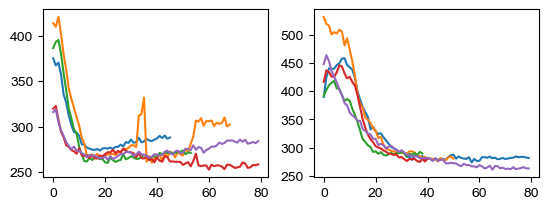

In [9]:
fig = plt.figure()
ax = fig.add_subplot(221)
for df in wt_trace_dfs:
    ax.plot(df.Mean_yfp)
    
ax2 =fig.add_subplot(222)
for df in rpn4d_trace_dfs:
    ax2.plot(df.Mean_yfp)

### 7. Plot chase window

Text(0.5, 0, 'Time after chase (hrs)')

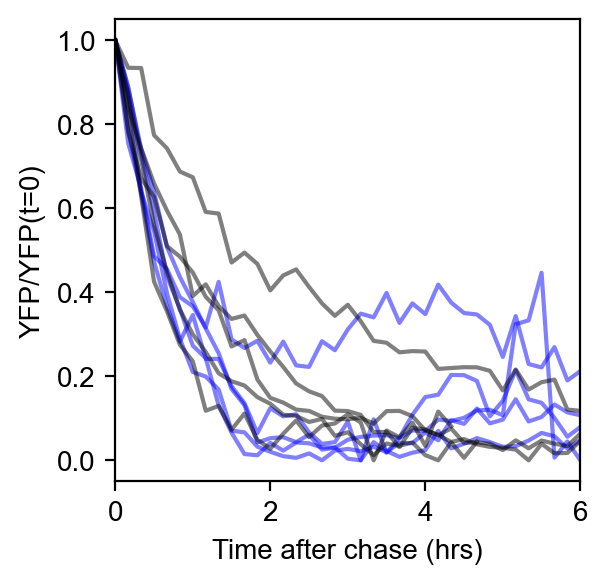

In [10]:
colors = ['blue', 'black']
wt_chase_frame = 2
rpn4d_chase_frame = 12
chase_duration = 56

fig = plt.figure(figsize=(3, 3))
fig.set_dpi(200)
ax = plt.axes()

# Plot WT cells
dfs = wt_trace_dfs
chase_frame = wt_chase_frame
start_frame = chase_frame
offset = (start_frame*10)/60

for i, df in enumerate(dfs):
    df.loc[:, 'mean_yfp_bg_sub'] = df.Mean_yfp - df.Mean_yfp.min()
    df.loc[:, 'norm_yfp'] = df.mean_yfp_bg_sub/df.loc[chase_frame, 'mean_yfp_bg_sub']
    
    x = df.hours[start_frame:start_frame + chase_duration] - offset
    y = df.norm_yfp[start_frame:start_frame + chase_duration]
    ax.plot(x, y,
            color=colors[0], alpha=0.5)
    
# Plot rpn4d cells
dfs = rpn4d_trace_dfs
chase_frame = rpn4d_chase_frame
start_frame = chase_frame
offset = (start_frame*10)/60

for i, df in enumerate(dfs):
    df.loc[:, 'mean_yfp_bg_sub'] = df.Mean_yfp - df.Mean_yfp.min()
    df.loc[:, 'norm_yfp'] = df.mean_yfp_bg_sub/df.loc[chase_frame, 'mean_yfp_bg_sub']
    
    x = df.hours[start_frame:start_frame + chase_duration] - offset
    y = df.norm_yfp[start_frame:start_frame + chase_duration]
    ax.plot(x, y,
            color=colors[1], alpha=0.5)
    
# ax.set_ylim(0, 1.2)
ax.set_xlim(0, 6)

ax.set_ylabel('YFP/YFP(t=0)')
ax.set_xlabel('Time after chase (hrs)')

In [19]:
df = wt_trace_dfs[0]

In [ ]:
df.

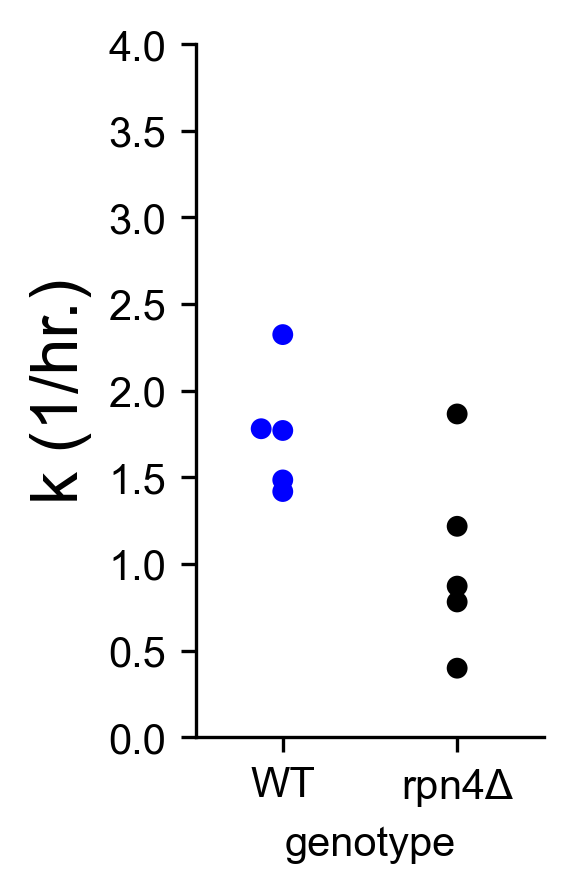

In [11]:
from byc import fitting_tools as ft
wt_chase_start = 2
rpn4d_chase_start = 12
window = 36
wt_fits_df = ft.get_all_fits_df(wt_trace_dfs, wt_chase_start, wt_chase_start+window, col_name='Mean_yfp')
rpn4d_fits_df = ft.get_all_fits_df(rpn4d_trace_dfs, rpn4d_chase_start, rpn4d_chase_start+window, col_name='Mean_yfp')
wt_fits_df.loc[:, 'genotype'] = 'BY4741'
rpn4d_fits_df.loc[:, 'genotype'] = 'rpn4d'
all_fits_df = pd.concat([wt_fits_df, rpn4d_fits_df], ignore_index=True)
all_fits_df.loc[:, "substrate"] = 'UBL-sYFP2-NS'
all_fits_table = pd.pivot_table(all_fits_df, index=['cell_index', 'genotype'], aggfunc=np.mean).reset_index()
palette = sns.color_palette(['blue', 'black'])

fig = plt.figure(figsize=(1.5, 3))
fig.set_dpi(300)
ax = sns.swarmplot(x='genotype', y='b', data=all_fits_table,
                   palette=palette)
ax.set_ylim(0, 4)
ax.set_ylabel('k (1/hr.)', fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xticklabels(['WT', r'rpn4$\Delta$'])

fig.savefig('20210205_byc_pJC031_decay_in_BY4741_rpn4d.svg')

In [74]:
df1 = all_fits_df
table1 = all_fits_table

# 20210212_byc - Young pJC183 250 &mu;M Tet chase in BY4741, rpn4&Delta;

In [54]:
import os
import shutil

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

plt.style.use('default')
matplotlib.rcParams['font.sans-serif'] = 'Arial'

from byc import standard_analysis as sa
from byc import files
import byc.fitting_tools as ft

In [55]:
from importlib import reload
reload(sa)

<module 'byc.standard_analysis' from 'C:\\Users\\John Cooper\\Projects\\byc\\byc\\standard_analysis.py'>

### 1. Create master df from .csvs generated by running the Fiji plugin `imagejpc/save cell roi set` and selecting entering 'crop' as roi type

In [3]:
# Create master index for running byc/bin/run_segmentation.py
df_paths = files.select_files("Choose .csvs")
dfs = [pd.read_csv(path) for path in df_paths]
mdf = pd.concat(dfs, ignore_index=True)
compartment_dir = os.path.dirname(df_paths[0])
write_path = os.path.join(compartment_dir, '20210212_byc_pJC183_BY4741_young_chase_master_index.csv')
mdf.to_csv(write_path, index=False)
WT_mdf = pd.read_csv(write_path)

In [25]:
# Create master index for running byc/bin/run_segmentation.py
df_paths = files.select_files("Choose .csvs")
dfs = [pd.read_csv(path) for path in df_paths]
mdf = pd.concat(dfs, ignore_index=True)
compartment_dir = os.path.dirname(df_paths[0])
write_path = os.path.join(compartment_dir, '20210212_byc_pJC183_rpn4d_young_chase_master_index.csv')
mdf.to_csv(write_path, index=False)
rpn4d_mdf = pd.read_csv(write_path)

### 2. After creating master index, run `byc/bin/run_segmentation` and when prompted select the master index file created above

### 3. Use Fiji to curate cell outlines created in `run_segmentation`

    A.) Open the cropped cell stacks (all channels as well as the otsu_thresholded one)
    B.) Make the otsu thresholded stack the active image. Press 'g' to convert the stack to a mask (cell area should be black after this).
    C.) Press '8' to run a watershed on the stack (find edges between overlapping/adjacent blobs)
    D.) Press 'q' to set measurements. Choose desired measurements (more the better). Choose None for redirect image
    E.) Press 'u' to run 'Analyze Particles'. At 60x, set Size range to 100-1000 square pixels and circularity to 0.8-1. Check 'Add to manager' and 'Exclude on edges. 'Click 'OK'
    F.) In ROI manager, delete or redraw bad ROIs. Add new ones so that there are at least one for the first and last frames and a every 10-20 frames, then run `imagejpc/save cell roi set` and select 'measurement' as ROI type

### 4. To quantify cell fluorescence traces using the ROIs above, , run `imagejpc/measure rois` with the cell's cropped channel stacks and measurement_rois.zip files open

### 5. Read in traces

In [79]:
WT_mdf_path = r"C:\Users\John Cooper\Projects\byc\data\20210212_byc\20210212_byc_pJC183_BY4741_young_chase_master_index.csv"
WT_mdf = pd.read_csv(WT_mdf_path)

rpn4d_mdf_path = r"C:\Users\John Cooper\Projects\byc\data\20210212_byc\20210212_byc_pJC183_rpn4d_young_chase_master_index.csv"
rpn4d_mdf = pd.read_csv(rpn4d_mdf_path)

In [80]:
wt_ds = sa.bycDataSet(mdf=WT_mdf)
wt_trace_dfs = wt_ds.cell_trace_dfs

rpn4d_ds = sa.bycDataSet(mdf=rpn4d_mdf)
rpn4d_trace_dfs = rpn4d_ds.cell_trace_dfs

Found data for cell 0 at C:\Users\John Cooper\Projects\byc\data\20210212_byc\20200212_byc_pJC183_BY4741_young_chase\20210212_byc_xy01_cell000_bf_stack.csv
Looking for crop ROIs at C:\Users\John Cooper\Projects\byc\data\20210212_byc\20200212_byc_pJC183_BY4741_young_chase\20210212_byc_cell000_crop_rois.zip
Found data for cell 0 at C:\Users\John Cooper\Projects\byc\data\20210212_byc\20200212_byc_pJC183_BY4741_young_chase\20210212_byc_xy01_cell000_rfp_stack.csv
Looking for crop ROIs at C:\Users\John Cooper\Projects\byc\data\20210212_byc\20200212_byc_pJC183_BY4741_young_chase\20210212_byc_cell000_crop_rois.zip
Found data for cell 1 at C:\Users\John Cooper\Projects\byc\data\20210212_byc\20200212_byc_pJC183_BY4741_young_chase\20210212_byc_xy01_cell001_bf_stack.csv
Looking for crop ROIs at C:\Users\John Cooper\Projects\byc\data\20210212_byc\20200212_byc_pJC183_BY4741_young_chase\20210212_byc_cell001_crop_rois.zip
Found data for cell 1 at C:\Users\John Cooper\Projects\byc\data\20210212_byc\2020

### Plot raw traces

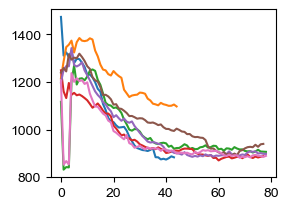

In [6]:
fig = plt.figure()
ax = fig.add_subplot(221)
for df in wt_trace_dfs:
    ax.plot(df.Mean_rfp)


Text(0.5, 0, 'Time after chase (hrs)')

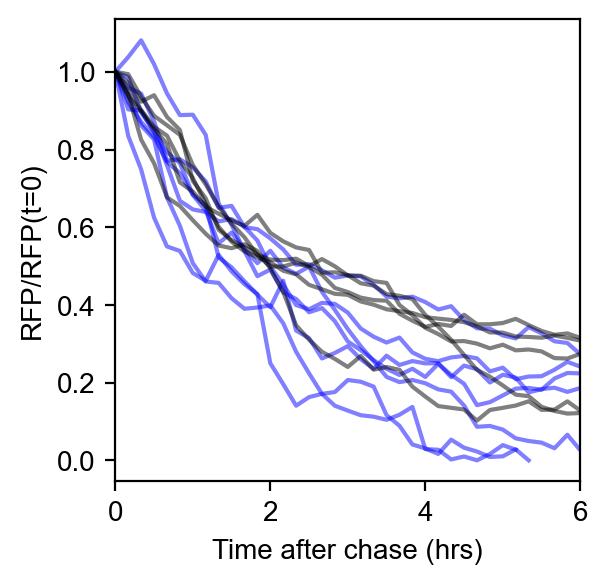

In [81]:
colors = ['blue', 'black']
chase_duration = 56

fig = plt.figure(figsize=(3, 3))
fig.set_dpi(200)
ax = plt.axes()

# Plot WT cells
dfs = wt_trace_dfs
chase_frame = 12
start_frame = chase_frame
offset = (start_frame*10)/60

for i, df in enumerate(dfs):
    df.loc[:, 'mean_rfp_bg_sub'] = df.Mean_rfp - df.Mean_rfp.min()
    df.loc[:, 'norm_rfp'] = df.mean_rfp_bg_sub/df.loc[chase_frame, 'mean_rfp_bg_sub']
    
    x = df.hours[start_frame:start_frame + chase_duration] - offset
    y = df.norm_rfp[start_frame:start_frame + chase_duration]
    ax.plot(x, y,
            color=colors[0], alpha=0.5)
    
# Plot rpn4d cells
dfs = rpn4d_trace_dfs
chase_frame = 13
start_frame = chase_frame
offset = (start_frame*10)/60

for i, df in enumerate(dfs):
    df.loc[:, 'mean_rfp_bg_sub'] = df.Mean_rfp - df.Mean_rfp.min()
    df.loc[:, 'norm_rfp'] = df.mean_rfp_bg_sub/df.loc[chase_frame, 'mean_rfp_bg_sub']
    
    x = df.hours[start_frame:start_frame + chase_duration] - offset
    y = df.norm_rfp[start_frame:start_frame + chase_duration]
    ax.plot(x, y,
            color=colors[1], alpha=0.5)
    
# ax.set_ylim(0, 1.2)
ax.set_xlim(0, 6)

ax.set_ylabel('RFP/RFP(t=0)')
ax.set_xlabel('Time after chase (hrs)')

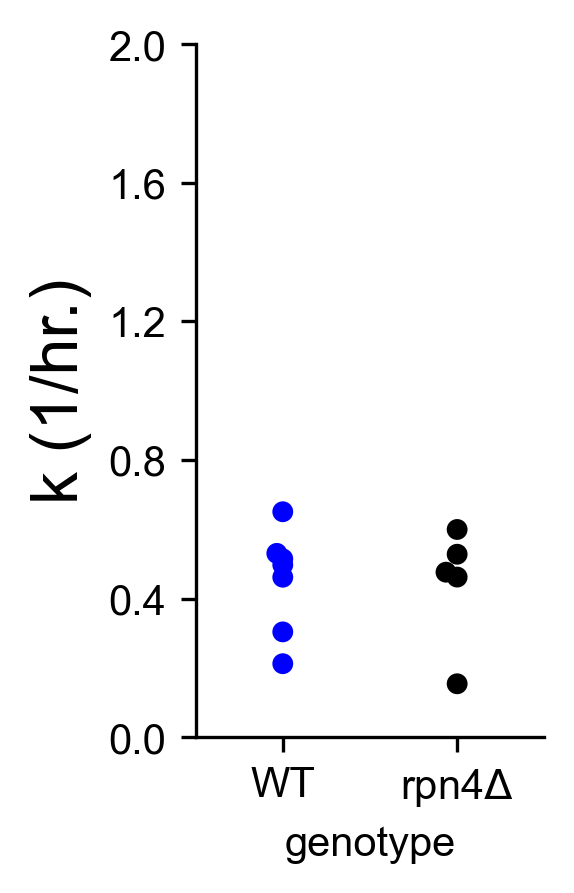

In [82]:
from byc import fitting_tools as ft

wt_fits_df = ft.get_all_fits_df(wt_trace_dfs, 12, 48, col_name='Mean_rfp')
rpn4d_fits_df = ft.get_all_fits_df(rpn4d_trace_dfs, 13, 49, col_name='Mean_rfp')
wt_fits_df.loc[:, 'genotype'] = 'BY4741'
rpn4d_fits_df.loc[:, 'genotype'] = 'rpn4d'
all_fits_df = pd.concat([wt_fits_df, rpn4d_fits_df], ignore_index=True)
all_fits_df.loc[:, "substrate"] = 'UBL-mScarletI-NS'
all_fits_table = pd.pivot_table(all_fits_df, index=['cell_index', 'genotype'], aggfunc=np.mean).reset_index()

palette = sns.color_palette(['blue', 'black'])

fig = plt.figure(figsize=(1.5, 3))
fig.set_dpi(300)
ax = sns.swarmplot(x='genotype', y='b', data=all_fits_table,
                   palette=palette)
ax.set_ylim(0, 2)
ax.set_yticks(np.arange(0, 2.1, 0.4))
ax.set_ylabel('k (1/hr.)', fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xticklabels(['WT', r'rpn4$\Delta$'])

fig.savefig('20210205_byc_pJC031_decay_in_BY4741_rpn4d.svg')

In [83]:
df2 = all_fits_df
table2 = all_fits_table

# 20210317_byc - Young pJC289 250 &mu;M Tet chase in CMY3465, rpn4&Delta;

In [2]:
import os
import shutil

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

plt.style.use('default')
matplotlib.rcParams['font.sans-serif'] = 'Arial'

from byc import standard_analysis as sa
from byc import files
import byc.fitting_tools as ft

In [3]:
from importlib import reload
reload(sa)

<module 'byc.standard_analysis' from 'C:\\Users\\John Cooper\\Projects\\byc\\byc\\standard_analysis.py'>

### 1. Create master df from .csvs generated by running the Fiji plugin `imagejpc/save cell roi set` and selecting entering 'crop' as roi type

In [4]:
# Create master index for running byc/bin/run_segmentation.py
df_paths = files.select_files("Choose .csvs")
dfs = [pd.read_csv(path) for path in df_paths]
mdf = pd.concat(dfs, ignore_index=True)
compartment_dir = os.path.dirname(df_paths[0])
write_path = os.path.join(compartment_dir, '20210317_byc_pJC289_CMY3465_young_chase_master_index.csv')
mdf.to_csv(write_path, index=False)
WT_mdf = pd.read_csv(write_path)

In [5]:
# Create master index for running byc/bin/run_segmentation.py
df_paths = files.select_files("Choose .csvs")
dfs = [pd.read_csv(path) for path in df_paths]
mdf = pd.concat(dfs, ignore_index=True)
compartment_dir = os.path.dirname(df_paths[0])
write_path = os.path.join(compartment_dir, '20210317_byc_pJC289_rpn4d_young_chase_master_index.csv')
mdf.to_csv(write_path, index=False)
rpn4d_mdf = pd.read_csv(write_path)

### 2. After creating master index, run `byc/bin/run_segmentation` and when prompted select the master index file created above

### 3. Use Fiji to curate cell outlines created in `run_segmentation`

    A.) Open the cropped cell stacks (all channels as well as the otsu_thresholded one)
    B.) Make the otsu thresholded stack the active image. Press 'g' to convert the stack to a mask (cell area should be black after this).
    C.) Press '8' to run a watershed on the stack (find edges between overlapping/adjacent blobs)
    D.) Press 'q' to set measurements. Choose desired measurements (more the better). Choose None for redirect image
    E.) Press 'u' to run 'Analyze Particles'. At 60x, set Size range to 100-1000 square pixels and circularity to 0.8-1. Check 'Add to manager' and 'Exclude on edges. 'Click 'OK'
    F.) In ROI manager, delete or redraw bad ROIs. Add new ones so that there are at least one for the first and last frames and a every 10-20 frames, then run `imagejpc/save cell roi set` and select 'measurement' as ROI type

### 4. To quantify cell fluorescence traces using the ROIs above, , run `imagejpc/measure rois` with the cell's cropped channel stacks and measurement_rois.zip files open

### 5. Read in traces

In [84]:
WT_mdf_path = r"C:\Users\John Cooper\Projects\byc\data\20210317_byc\20210317_byc_pJC289_CMY3465_young_chase_master_index.csv"
WT_mdf = pd.read_csv(WT_mdf_path)

rpn4d_mdf_path = r"C:\Users\John Cooper\Projects\byc\data\20210317_byc\20210317_byc_pJC289_rpn4d_young_chase_master_index.csv"
rpn4d_mdf = pd.read_csv(rpn4d_mdf_path)

In [85]:
wt_ds = sa.bycDataSet(mdf=WT_mdf)
wt_trace_dfs = wt_ds.cell_trace_dfs

rpn4d_ds = sa.bycDataSet(mdf=rpn4d_mdf)
rpn4d_trace_dfs = rpn4d_ds.cell_trace_dfs

Found data for cell 0 at C:\Users\John Cooper\Projects\byc\data\20210317_byc\20210317_byc_pJC289_CMY3465_young_decay\20210317_byc_xy00_cell000_bf_stack.csv
Looking for crop ROIs at C:\Users\John Cooper\Projects\byc\data\20210317_byc\20210317_byc_pJC289_CMY3465_young_decay\20210317_byc_cell000_crop_rois.zip
Found data for cell 0 at C:\Users\John Cooper\Projects\byc\data\20210317_byc\20210317_byc_pJC289_CMY3465_young_decay\20210317_byc_xy00_cell000_rfp_stack.csv
Looking for crop ROIs at C:\Users\John Cooper\Projects\byc\data\20210317_byc\20210317_byc_pJC289_CMY3465_young_decay\20210317_byc_cell000_crop_rois.zip
Found data for cell 1 at C:\Users\John Cooper\Projects\byc\data\20210317_byc\20210317_byc_pJC289_CMY3465_young_decay\20210317_byc_xy00_cell001_bf_stack.csv
Looking for crop ROIs at C:\Users\John Cooper\Projects\byc\data\20210317_byc\20210317_byc_pJC289_CMY3465_young_decay\20210317_byc_cell001_crop_rois.zip
Found data for cell 1 at C:\Users\John Cooper\Projects\byc\data\20210317_by

### Plot raw traces

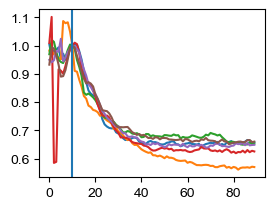

In [48]:
fig = plt.figure()
ax = fig.add_subplot(221)
start_frame = 10
for df in wt_trace_dfs:
    y = df.Mean_rfp/df.Mean_rfp[start_frame]
    ax.plot(y[:])
ax.axvline(start_frame)

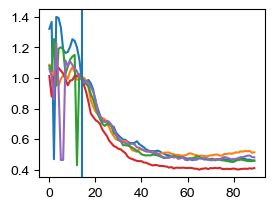

In [51]:
fig = plt.figure()
ax = fig.add_subplot(221)
start_frame = 14
for df in rpn4d_trace_dfs:
    y = df.Mean_rfp/df.Mean_rfp[start_frame]
    ax.plot(y[:])
ax.axvline(start_frame)

Text(0.5, 0, 'Time after chase (hrs)')

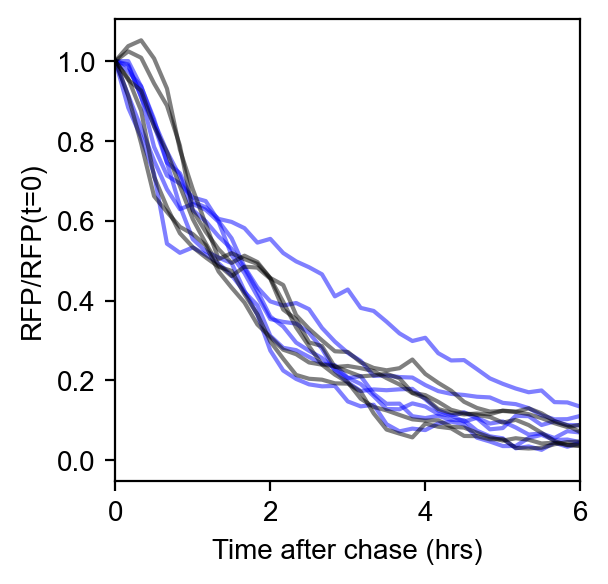

In [86]:
colors = ['blue', 'black']
chase_duration = 56

fig = plt.figure(figsize=(3, 3))
fig.set_dpi(200)
ax = plt.axes()
wt_trace_frame = 11
rpn4d_chase_frame = 15
# Plot WT cells
dfs = wt_trace_dfs
chase_frame = wt_trace_frame
start_frame = chase_frame
offset = (start_frame*10)/60

for i, df in enumerate(dfs):
    df.loc[:, 'mean_rfp_bg_sub'] = df.Mean_rfp - df.Mean_rfp.min()
    df.loc[:, 'norm_rfp'] = df.mean_rfp_bg_sub/df.loc[chase_frame, 'mean_rfp_bg_sub']
    
    x = df.hours[start_frame:start_frame + chase_duration] - offset
    y = df.norm_rfp[start_frame:start_frame + chase_duration]
    ax.plot(x, y,
            color=colors[0], alpha=0.5)
    
# Plot rpn4d cells
dfs = rpn4d_trace_dfs
chase_frame = rpn4d_chase_frame
start_frame = chase_frame
offset = (start_frame*10)/60

for i, df in enumerate(dfs):
    df.loc[:, 'mean_rfp_bg_sub'] = df.Mean_rfp - df.Mean_rfp.min()
    df.loc[:, 'norm_rfp'] = df.mean_rfp_bg_sub/df.loc[chase_frame, 'mean_rfp_bg_sub']
    
    x = df.hours[start_frame:start_frame + chase_duration] - offset
    y = df.norm_rfp[start_frame:start_frame + chase_duration]
    ax.plot(x, y,
            color=colors[1], alpha=0.5)
    
# ax.set_ylim(0, 1.2)
ax.set_xlim(0, 6)

ax.set_ylabel('RFP/RFP(t=0)')
ax.set_xlabel('Time after chase (hrs)')

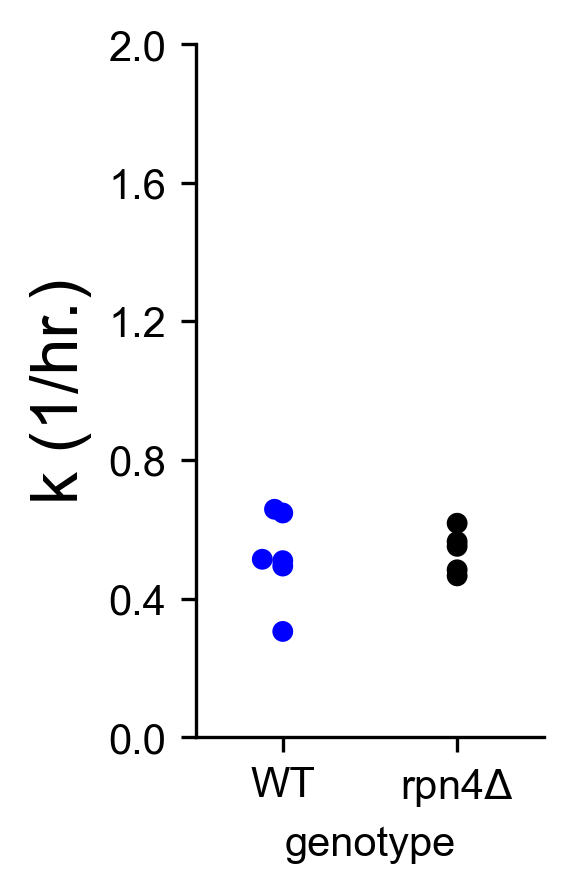

In [87]:
from byc import fitting_tools as ft

wt_fits_df = ft.get_all_fits_df(wt_trace_dfs, wt_trace_frame, 48, col_name='Mean_rfp')
rpn4d_fits_df = ft.get_all_fits_df(rpn4d_trace_dfs, rpn4d_chase_frame, 49, col_name='Mean_rfp')
wt_fits_df.loc[:, 'genotype'] = 'BY4741'
rpn4d_fits_df.loc[:, 'genotype'] = 'rpn4d'
all_fits_df = pd.concat([wt_fits_df, rpn4d_fits_df], ignore_index=True)
all_fits_df.loc[:, "substrate"] = 'UBL-mScarletI-Su9'
all_fits_table = pd.pivot_table(all_fits_df, index=['cell_index', 'genotype'], aggfunc=np.mean).reset_index()

palette = sns.color_palette(['blue', 'black'])

fig = plt.figure(figsize=(1.5, 3))
fig.set_dpi(300)
ax = sns.swarmplot(x='genotype', y='b', data=all_fits_table,
                   palette=palette)
ax.set_ylim(0, 2)
ax.set_yticks(np.arange(0, 2.1, 0.4))
ax.set_ylabel('k (1/hr.)', fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xticklabels(['WT', r'rpn4$\Delta$'])

fig.savefig('20210205_byc_pJC031_decay_in_BY4741_rpn4d.svg')

In [88]:
df3 = all_fits_df
table3 = all_fits_table

### Comparison of UBL-sYFP2-NS to UBL-mScarletI-NS/Su9

In [348]:
import os
import shutil

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

plt.style.use('default')
matplotlib.rcParams['font.sans-serif'] = 'Arial'
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

from byc import standard_analysis as sa
from byc import files
import byc.fitting_tools as ft

In [2]:
from importlib import reload
reload(sa)

<module 'byc.standard_analysis' from 'C:\\Users\\John Cooper\\Projects\\byc\\byc\\standard_analysis.py'>

In [98]:
# dfs = [df1, df2, df3]
# tables = [table1, table2, table3]
# fits_df = pd.concat(dfs, ignore_index=True)
# fits_table = all_fits_table = pd.pivot_table(fits_df, index=['cell_index', 'genotype', 'substrate'], aggfunc=np.mean).reset_index()

In [3]:
fits_df = pd.read_csv('multi_expt_fits_df.csv')
fits_df.loc[:, 'halflife'] = np.log(2)/fits_df.b
fits_table = all_fits_table = pd.pivot_table(fits_df, index=['cell_index', 'genotype', 'substrate'], aggfunc=np.mean).reset_index()


In [4]:
fits_table

,cell_index,genotype,substrate,Unnamed: 0,a,b,c,est_std_err,halflife,r_sq,residual,shapiro_p,x_input,y_input_norm,y_input_raw,y_pred_norm
0,0,BY4741,UBL-mScarletI-NS,403.5,1.090459,0.514675,-0.076391,0.038269,1.346766,0.983968,5.449036e-11,0.254591,2.583333,0.311518,107.436688,0.311518
1,0,BY4741,UBL-mScarletI-Su9,972.0,1.099330,0.657747,0.004557,0.031277,1.053821,0.988264,8.641787e-10,0.343382,4.000000,0.219631,96.461714,0.219631
2,0,BY4741,UBL-sYFP2-NS,19.0,1.011501,1.780272,0.060681,0.050702,0.389349,0.952037,-2.115050e-10,0.020133,3.166667,0.161700,15.691359,0.161700
3,0,rpn4d,UBL-mScarletI-NS,722.5,1.070761,0.527938,0.004150,0.029424,1.312934,0.989591,-2.249971e-09,0.301695,4.083333,0.255275,171.588100,0.255275
4,0,rpn4d,UBL-mScarletI-Su9,1266.5,1.123553,0.465541,0.000401,0.041218,1.488908,0.981941,3.341951e-08,0.000439,4.083333,0.295176,297.566960,0.295176
5,0,rpn4d,UBL-sYFP2-NS,219.0,0.940103,0.780461,0.032546,0.025152,0.888125,0.988904,-1.653643e-10,0.451810,4.000000,0.189575,28.317122,0.189575
6,1,BY4741,UBL-mScarletI-NS,436.0,0.980609,0.497325,-0.068065,0.055995,1.393752,0.958432,-5.229437e-11,0.070410,2.666667,0.281266,79.047909,0.281266
7,1,BY4741,UBL-mScarletI-Su9,1021.0,1.076162,0.305154,-0.102684,0.027192,2.271466,0.990950,-8.863882e-11,0.319299,4.000000,0.303577,129.646224,0.303577
8,1,BY4741,UBL-sYFP2-NS,58.0,0.995600,1.417882,0.085171,0.097571,0.488861,0.853862,3.290803e-11,0.000002,3.166667,0.206452,33.226615,0.206452
9,1,rpn4d,UBL-mScarletI-NS,772.5,1.080265,0.476140,-0.024308,0.048299,1.455763,0.973345,4.142492e-10,0.135049,4.083333,0.253536,129.736940,0.253536


In [200]:
scatter = all_fits_table = pd.pivot_table(fits_df, index=['genotype',
                                                          'substrate',
                                                          'x_input'], aggfunc=np.median).reset_index()

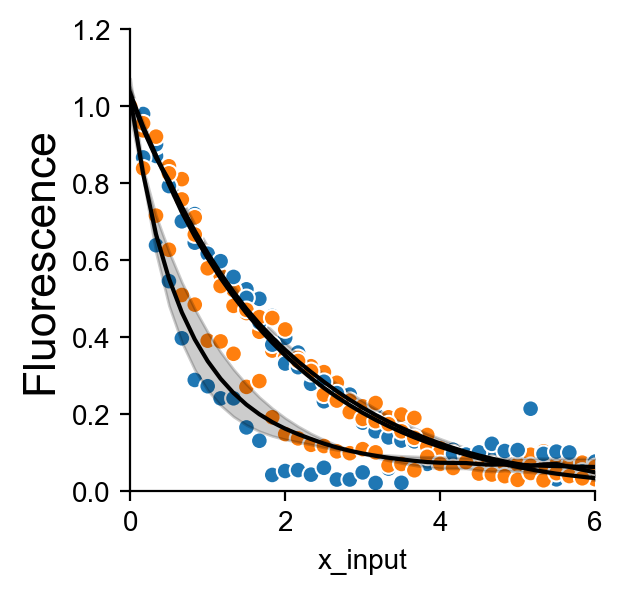

In [201]:
fig = plt.figure(figsize=(3, 3))
fig.set_dpi(200)
ax = plt.axes()
i=0
colors = ['blue', 'black']
for substrate in scatter.substrate.unique():
    df = scatter[scatter.substrate==substrate]
    sns.scatterplot(x='x_input',
                    y='y_input_norm',
                    hue='genotype',
                    data=df,
                    ax=ax)
    sns.lineplot(x='x_input',
                 y='y_pred_norm',
                 style='substrate',
                 data=df, ax=ax, color=color, legend=False)
    i+=1

ax.set_xlim(0, 6)
ax.set_ylim(0, 1.2)
ax.set_ylabel('Fluorescence', fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend_.remove()

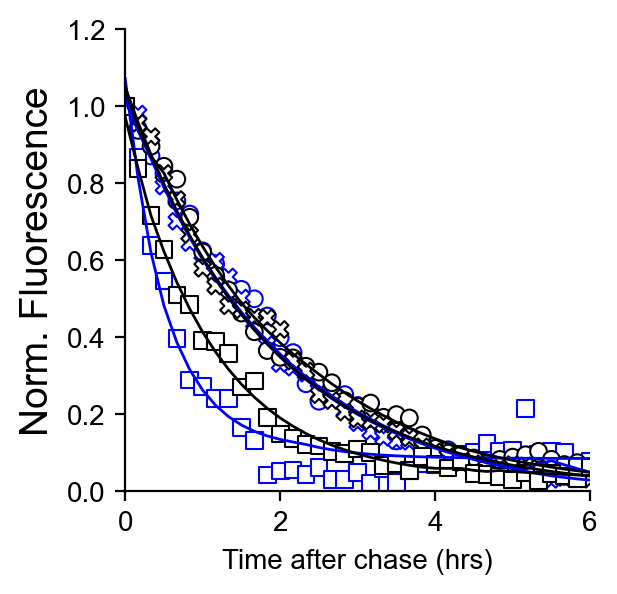

In [211]:
fig = plt.figure(figsize=(3, 3))
fig.set_dpi(200)
ax = plt.axes()
i=0
colors = ['blue', 'black']
for genotype in ['BY4741', 'rpn4d']:
    df = scatter[scatter.genotype==genotype]
    color=colors[i]
    sns.scatterplot(x='x_input',
                    y='y_input_norm',
                    style='substrate',
                    data=df, color='white', edgecolor=color,
                    ax=ax)
    for substrate in df.substrate.unique():
        subdf = df[df.substrate==substrate]
        ax.plot(subdf.x_input, subdf.y_pred_norm,
                color=color, linewidth=1)
    i+=1

ax.set_xlim(0, 6)
ax.set_ylim(0, 1.2)
ax.set_ylabel('Norm. Fluorescence', fontsize=14)
ax.set_xlabel('Time after chase (hrs)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend_.remove()

Text(0.5, 0, '')

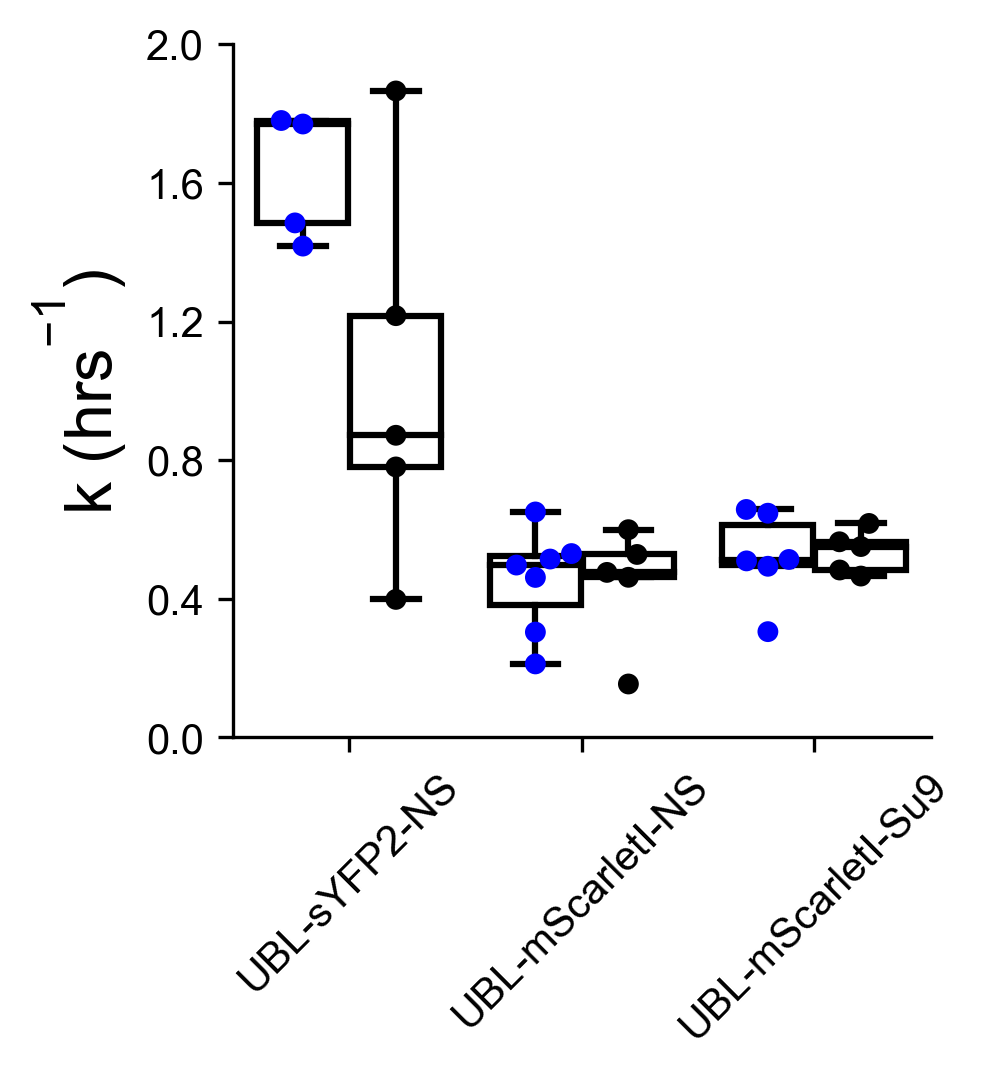

In [206]:
palette = sns.color_palette(['blue', 'black'])
order = ['UBL-sYFP2-NS',
         'UBL-mScarletI-NS', 
         'UBL-mScarletI-Su9']
fig = plt.figure(figsize=(3, 3))
fig.set_dpi(300)
ax = sns.boxplot(x='substrate', y='b', hue='genotype',
                   data=fits_table, dodge=True, order=order,
                   color='white', palette=palette, showfliers=False)
sns.swarmplot(x='substrate', y='b', hue='genotype',
             data=fits_table, dodge=True, ax=ax,
             palette=palette, order=order)

ax.set_ylim(0, 2)
ax.set_yticks(np.arange(0, 2.1, 0.4))
ax.set_ylabel(r'k (hrs$^{-1}$)', fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.legend_.remove()
for i,box in enumerate(ax.artists):
    box.set_edgecolor('black')
    box.set_facecolor('white')
ax.set_xlabel('')
# fig.savefig('20210205_byc_pJC031_decay_in_BY4741_rpn4d.svg')

Text(0.5, 0, '')

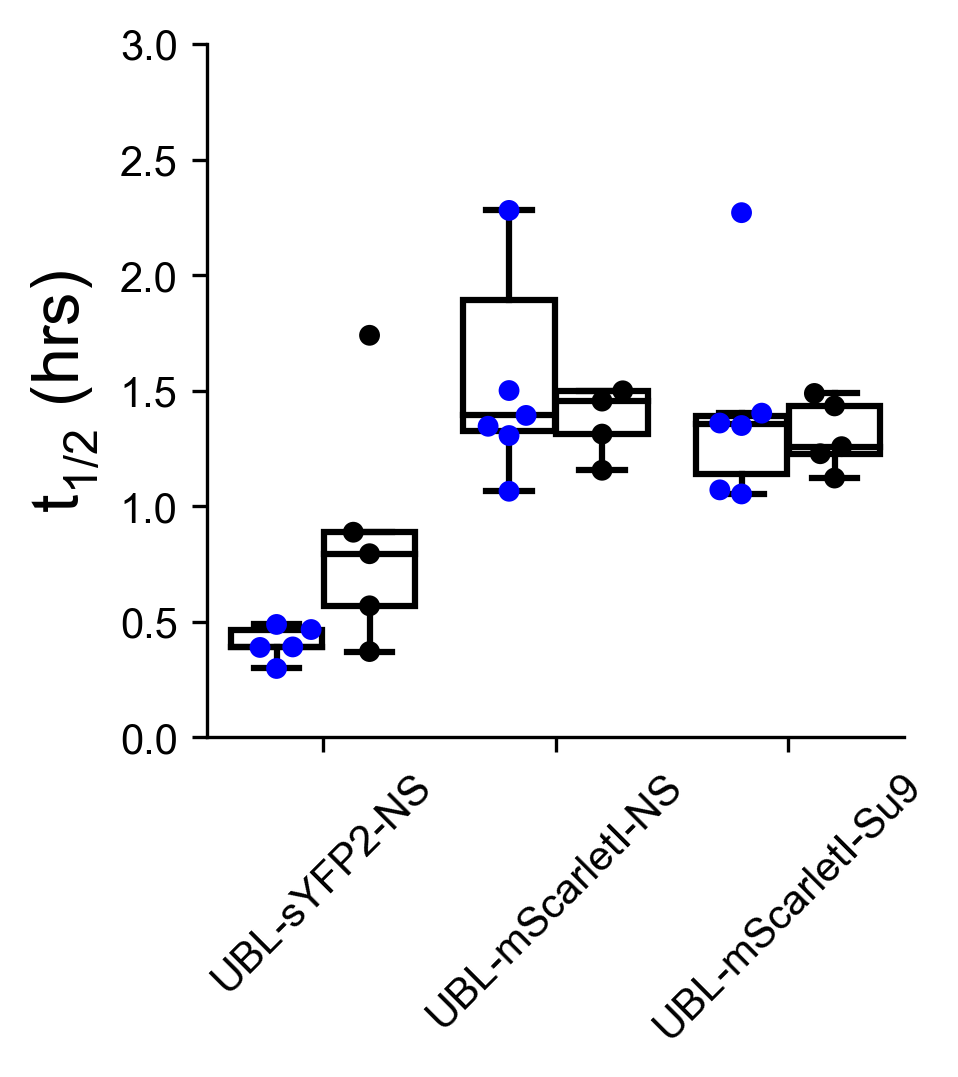

In [207]:
palette = sns.color_palette(['blue', 'black'])
order = ['UBL-sYFP2-NS',
         'UBL-mScarletI-NS', 
         'UBL-mScarletI-Su9']
fig = plt.figure(figsize=(3, 3))
fig.set_dpi(300)
ax = sns.boxplot(x='substrate', y='halflife', hue='genotype',
                   data=fits_table, dodge=True, order=order,
                   color='white', palette=palette, showfliers=False)
sns.swarmplot(x='substrate', y='halflife', hue='genotype',
             data=fits_table, dodge=True, ax=ax,
             palette=palette, order=order)

ax.set_ylim(0, 3)
# ax.set_yticks(np.arange(0, 2.1, 0.4))
ax.set_ylabel(r'$t_{1/2}$ (hrs)', fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.legend_.remove()
for i,box in enumerate(ax.artists):
    box.set_edgecolor('black')
    box.set_facecolor('white')
ax.set_xlabel('')
# fig.savefig('20210205_byc_pJC031_decay_in_BY4741_rpn4d.svg')

# 20210323_byc - Young pJC272 (NLS-mScarletI-VHL) 250 &mu;M Tet chase in BY4741, rpn4&Delta;

In [2]:
import os
import shutil

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

plt.style.use('default')
matplotlib.rcParams['font.sans-serif'] = 'Arial'

from byc import standard_analysis as sa
from byc import files
import byc.fitting_tools as ft

In [3]:
from importlib import reload
reload(sa)

<module 'byc.standard_analysis' from 'C:\\Users\\John Cooper\\Projects\\byc\\byc\\standard_analysis.py'>

### 1. Create master df from .csvs generated by running the Fiji plugin `imagejpc/save cell roi set` and selecting entering 'crop' as roi type

In [3]:
# Create master index for running byc/bin/run_segmentation.py
df_paths = files.select_files("Choose .csvs")
dfs = [pd.read_csv(path) for path in df_paths]
mdf = pd.concat(dfs, ignore_index=True)
compartment_dir = os.path.dirname(df_paths[0])
write_path = os.path.join(compartment_dir, '20210323_byc_pJC272_BY4741_young_chase_master_index.csv')
mdf.to_csv(write_path, index=False)
WT_mdf = pd.read_csv(write_path)

In [4]:
# Create master index for running byc/bin/run_segmentation.py
df_paths = files.select_files("Choose .csvs")
dfs = [pd.read_csv(path) for path in df_paths]
mdf = pd.concat(dfs, ignore_index=True)
compartment_dir = os.path.dirname(df_paths[0])
write_path = os.path.join(compartment_dir, '20210323_byc_pJC272_rpn4d_young_chase_master_index.csv')
mdf.to_csv(write_path, index=False)
rpn4d_mdf = pd.read_csv(write_path)

### 2. After creating master index, run `byc/bin/run_segmentation` and when prompted select the master index file created above

### 3. Use Fiji to curate cell outlines created in `run_segmentation`

    A.) Open the cropped cell stacks (all channels as well as the otsu_thresholded one)
    B.) Make the otsu thresholded stack the active image. Press 'g' to convert the stack to a mask (cell area should be black after this).
    C.) Press '8' to run a watershed on the stack (find edges between overlapping/adjacent blobs)
    D.) Press 'q' to set measurements. Choose desired measurements (more the better). Choose None for redirect image
    E.) Press 'u' to run 'Analyze Particles'. At 60x, set Size range to 100-1000 square pixels and circularity to 0.8-1. Check 'Add to manager' and 'Exclude on edges. 'Click 'OK'
    F.) In ROI manager, delete or redraw bad ROIs. Add new ones so that there are at least one for the first and last frames and a every 10-20 frames, then run `imagejpc/save cell roi set` and select 'measurement' as ROI type

### 4. To quantify cell fluorescence traces using the ROIs above, , run `imagejpc/measure rois` with the cell's cropped channel stacks and measurement_rois.zip files open

### 5. Read in traces

In [5]:
WT_mdf_path = r"C:\Users\John Cooper\Projects\byc\data\20210323_byc\20210323_byc_pJC272_BY4741_young_chase_master_index.csv"
WT_mdf = pd.read_csv(WT_mdf_path)

rpn4d_mdf_path = r"C:\Users\John Cooper\Projects\byc\data\20210323_byc\20210323_byc_pJC272_rpn4d_young_chase_master_index.csv"
rpn4d_mdf = pd.read_csv(rpn4d_mdf_path)

In [6]:
wt_ds = sa.bycDataSet(mdf=WT_mdf)
wt_trace_dfs = wt_ds.cell_trace_dfs

rpn4d_ds = sa.bycDataSet(mdf=rpn4d_mdf)
rpn4d_trace_dfs = rpn4d_ds.cell_trace_dfs

Found data for cell 0 at C:\Users\John Cooper\Projects\byc\data\20210323_byc\20210323_byc_pJC272_BY4741_young_chase\20210323_byc_xy07_cell000_bf_stack.csv
Looking for crop ROIs at C:\Users\John Cooper\Projects\byc\data\20210323_byc\20210323_byc_pJC272_BY4741_young_chase\20210323_byc_cell000_crop_rois.zip
Adding data from bf channel
Found data for cell 0 at C:\Users\John Cooper\Projects\byc\data\20210323_byc\20210323_byc_pJC272_BY4741_young_chase\20210323_byc_xy07_cell000_rfp_stack.csv
Looking for crop ROIs at C:\Users\John Cooper\Projects\byc\data\20210323_byc\20210323_byc_pJC272_BY4741_young_chase\20210323_byc_cell000_crop_rois.zip
Adding data from rfp channel
Found data for cell 1 at C:\Users\John Cooper\Projects\byc\data\20210323_byc\20210323_byc_pJC272_BY4741_young_chase\20210323_byc_xy07_cell001_bf_stack.csv
Looking for crop ROIs at C:\Users\John Cooper\Projects\byc\data\20210323_byc\20210323_byc_pJC272_BY4741_young_chase\20210323_byc_cell001_crop_rois.zip
Adding data from bf chan

Looking for crop ROIs at C:\Users\John Cooper\Projects\byc\data\20210323_byc\20210323_byc_pJC272_rpn4d_young_chase\20210323_byc_cell005_crop_rois.zip
Adding data from rfp channel
Found data for cell 6 at C:\Users\John Cooper\Projects\byc\data\20210323_byc\20210323_byc_pJC272_rpn4d_young_chase\20210323_byc_xy05_cell006_bf_stack.csv
Looking for crop ROIs at C:\Users\John Cooper\Projects\byc\data\20210323_byc\20210323_byc_pJC272_rpn4d_young_chase\20210323_byc_cell006_crop_rois.zip
Adding data from bf channel
Found data for cell 6 at C:\Users\John Cooper\Projects\byc\data\20210323_byc\20210323_byc_pJC272_rpn4d_young_chase\20210323_byc_xy05_cell006_rfp_stack.csv
Looking for crop ROIs at C:\Users\John Cooper\Projects\byc\data\20210323_byc\20210323_byc_pJC272_rpn4d_young_chase\20210323_byc_cell006_crop_rois.zip
Adding data from rfp channel


In [4]:
bg = 338

In [5]:
for df in wt_trace_dfs:
    bg = df.loc[:, y_var].min()
    print(bg)
    y = df.loc[start_frame:, y_var] - df.loc[start_frame:, y_var].min()
    x = [(i*10)/60 for i in range(len(y))]

NameError: name 'y_var' is not defined

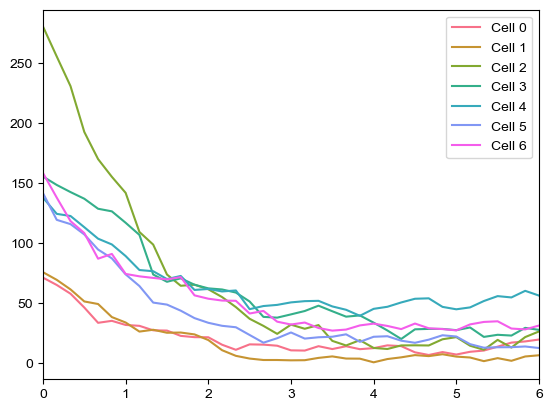

In [6]:
wt_start_frame = 4
dfs = wt_trace_dfs
y_var = 'Mean_rfp'
norm = False
ax = plt.axes()
ax.set_xlim(0, 6)
colors = sns.color_palette('husl', len(dfs))
for i, df in enumerate(dfs):
    y = df.loc[wt_start_frame:, y_var] - bg
    x = [(i*10)/60 for i in range(len(y))]
    if norm:
        y = y/y.iloc[0]
    ax.plot(x, y, color=colors[i], label=f'Cell {i}')
ax.legend()

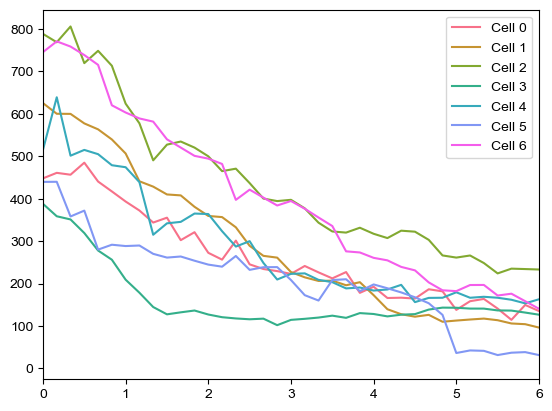

In [7]:
rpn4d_start_frame = 5
dfs = rpn4d_trace_dfs
y_var = 'Mean_rfp'
norm = False
ax = plt.axes()
ax.set_xlim(0, 6)
colors = sns.color_palette('husl', len(dfs))
for i, df in enumerate(dfs):
    y = df.loc[rpn4d_start_frame:, y_var] - bg
    x = [(i*10)/60 for i in range(len(y))]
    if norm:
        y = y/y.iloc[0]
    ax.plot(x, y, color=colors[i], label=f'Cell {i}')
ax.legend()

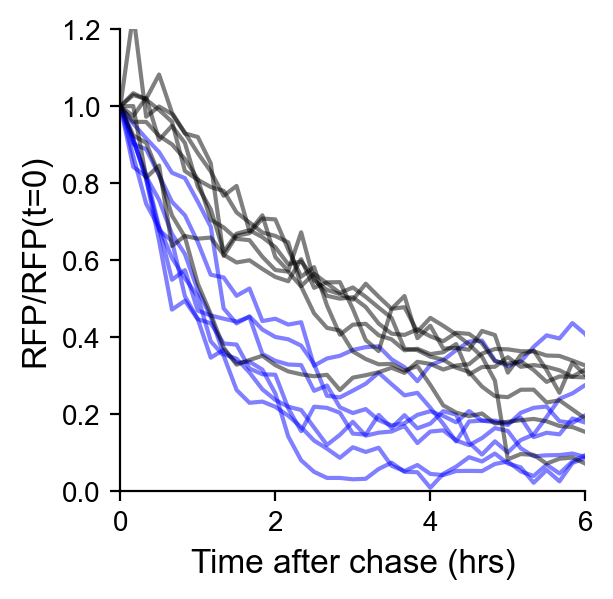

In [7]:
colors = ['blue', 'black']
chase_duration = 56
bg = 338
fig = plt.figure(figsize=(3, 3))
fig.set_dpi(200)
ax = plt.axes()
wt_chase_frame = 4
rpn4d_chase_frame = 5
# Plot WT cells
dfs = wt_trace_dfs
chase_frame = wt_chase_frame
start_frame = chase_frame
offset = (start_frame*10)/60

for i, df in enumerate(dfs):
    df.loc[:, 'mean_rfp_bg_sub'] = df.Mean_rfp - bg
    df.loc[:, 'norm_rfp'] = df.mean_rfp_bg_sub/df.loc[chase_frame, 'mean_rfp_bg_sub']
    
    x = df.hours[start_frame:start_frame + chase_duration] - offset
    y = df.norm_rfp[start_frame:start_frame + chase_duration]
    ax.plot(x, y,
            color=colors[0], alpha=0.5)
    
# Plot rpn4d cells
dfs = rpn4d_trace_dfs
chase_frame = rpn4d_chase_frame
start_frame = chase_frame
offset = (start_frame*10)/60

for i, df in enumerate(dfs):
    df.loc[:, 'mean_rfp_bg_sub'] = df.Mean_rfp - bg
    df.loc[:, 'norm_rfp'] = df.mean_rfp_bg_sub/df.loc[chase_frame, 'mean_rfp_bg_sub']
    
    x = df.hours[start_frame:start_frame + chase_duration] - offset
    y = df.norm_rfp[start_frame:start_frame + chase_duration]
    ax.plot(x, y,
            color=colors[1], alpha=0.5)
    
ax.set_ylabel('RFP/RFP(t=0)', fontsize=12)
ax.set_xlabel('Time after chase (hrs)', fontsize=12)
ax.set_xlim(0, 6)
ax.set_ylim(0, 1.2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [12]:
from byc import plotting
plotting.set_styles(plt, matplotlib)

[Text(0, 0, 'WT'), Text(0, 0, 'rpn4$\\Delta$')]

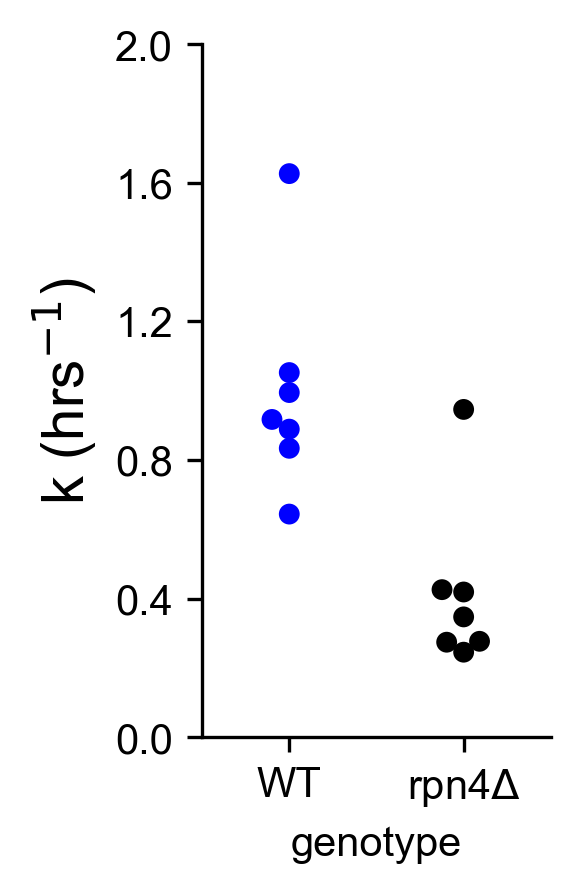

In [9]:
from byc import fitting_tools as ft
bg = 338
wt_fits_df = ft.get_all_fits_df(wt_trace_dfs, wt_chase_frame, 76,
                                col_name='Mean_rfp',
                                background=bg)
rpn4d_fits_df = ft.get_all_fits_df(rpn4d_trace_dfs, rpn4d_chase_frame, 77,
                                   col_name='Mean_rfp',
                                   background=bg)
wt_fits_df.loc[:, 'genotype'] = 'BY4741'
wt_fits_df.loc[:, 'age_state'] = 'young'
rpn4d_fits_df.loc[:, 'genotype'] = 'rpn4d'
rpn4d_fits_df.loc[:, 'age_state'] = 'young'
all_fits_df = pd.concat([wt_fits_df, rpn4d_fits_df], ignore_index=True)
all_fits_df.loc[:, 'halflife'] = np.log(2)/all_fits_df.b
all_fits_df.loc[:, "substrate"] = 'NLS-mScarletI-VHL'
all_fits_table = pd.pivot_table(all_fits_df, index=['cell_index', 'genotype'], aggfunc=np.mean).reset_index()
all_fits_df.to_csv('20210323_NLS-mScarletI-VHL_young_by4741_rpn4d_JPC008_JPC023_fits_df.csv')
palette = sns.color_palette(['blue', 'black'])

fig = plt.figure(figsize=(1.5, 3))
fig.set_dpi(300)
ax = sns.swarmplot(x='genotype', y='b', data=all_fits_table,
                   palette=palette, order=['BY4741', 'rpn4d'])
ax.set_ylim(0, 2)
ax.set_yticks(np.arange(0, 2.1, 0.4))
ax.set_ylabel(r'k (hrs$^{-1}$)', fontsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xticklabels(['WT', r'rpn4$\Delta$'])

[Text(0, 0, 'WT'), Text(0, 0, 'rpn4$\\Delta$')]

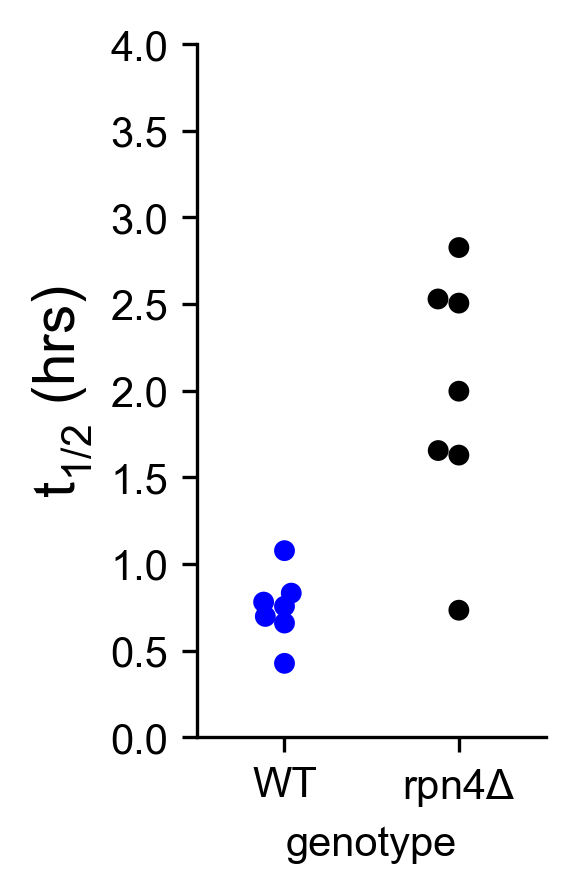

In [14]:
palette = sns.color_palette(['blue', 'black'])

fig = plt.figure(figsize=(1.5, 3))
fig.set_dpi(300)
ax = sns.swarmplot(x='genotype', y='halflife', data=all_fits_table,
                   palette=palette, order=['BY4741', 'rpn4d'])
ax.set_ylim(0, 4)
ax.set_ylabel(r't$_{1/2}$ (hrs)', fontsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xticklabels(['WT', r'rpn4$\Delta$'])

# 20210324_byc - Young pJC071 (UBL-mScarletI-NS in CEN4 TDH3_TetAptx2) 250 &mu;M Tet chase in BY4741, rpn4&Delta;

In [5]:
import os
import shutil

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

plt.style.use('default')
matplotlib.rcParams['font.sans-serif'] = 'Arial'
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

from byc import standard_analysis as sa
from byc import files
import byc.fitting_tools as ft

In [6]:
from importlib import reload
reload(sa)

<module 'byc.standard_analysis' from 'C:\\Users\\John Cooper\\Projects\\byc\\byc\\standard_analysis.py'>

### 1. Create master df from .csvs generated by running the Fiji plugin `imagejpc/save cell roi set` and selecting entering 'crop' as roi type

In [22]:
# Create master index for running byc/bin/run_segmentation.py
df_paths = files.select_files("Choose .csvs")
dfs = [pd.read_csv(path) for path in df_paths]
mdf = pd.concat(dfs, ignore_index=True)
compartment_dir = os.path.dirname(df_paths[0])
write_path = os.path.join(compartment_dir, '20210324_byc_pJC071_BY4741_young_chase_master_index.csv')
mdf.to_csv(write_path, index=False)
WT_mdf = pd.read_csv(write_path)

In [23]:
# Create master index for running byc/bin/run_segmentation.py
df_paths = files.select_files("Choose .csvs")
dfs = [pd.read_csv(path) for path in df_paths]
mdf = pd.concat(dfs, ignore_index=True)
compartment_dir = os.path.dirname(df_paths[0])
write_path = os.path.join(compartment_dir, '20210324_byc_pJC071_rpn4d_young_chase_master_index.csv')
mdf.to_csv(write_path, index=False)
rpn4d_mdf = pd.read_csv(write_path)

### 2. After creating master index, run `byc/bin/run_segmentation` and when prompted select the master index file created above

### 3. Use Fiji to curate cell outlines created in `run_segmentation`

    A.) Open the cropped cell stacks (all channels as well as the otsu_thresholded one)
    B.) Make the otsu thresholded stack the active image. Press 'g' to convert the stack to a mask (cell area should be black after this).
    C.) Press '8' to run a watershed on the stack (find edges between overlapping/adjacent blobs)
    D.) Press 'q' to set measurements. Choose desired measurements (more the better). Choose None for redirect image
    E.) Press 'u' to run 'Analyze Particles'. At 60x, set Size range to 100-1000 square pixels and circularity to 0.8-1. Check 'Add to manager' and 'Exclude on edges. 'Click 'OK'
    F.) In ROI manager, delete or redraw bad ROIs. Add new ones so that there are at least one for the first and last frames and a every 10-20 frames, then run `imagejpc/save cell roi set` and select 'measurement' as ROI type

### 4. To quantify cell fluorescence traces using the ROIs above, , run `imagejpc/measure rois` with the cell's cropped channel stacks and measurement_rois.zip files open

### 5. Read in traces

In [7]:
WT_mdf_path = r"C:\Users\John Cooper\Projects\byc\data\20210324_byc\20210324_byc_pJC071_BY4741_young_chase_master_index.csv"
WT_mdf = pd.read_csv(WT_mdf_path)

rpn4d_mdf_path = r"C:\Users\John Cooper\Projects\byc\data\20210324_byc\20210324_byc_pJC071_rpn4d_young_chase_master_index.csv"
rpn4d_mdf = pd.read_csv(rpn4d_mdf_path)

In [8]:
wt_ds = sa.bycDataSet(mdf=WT_mdf)
wt_trace_dfs = wt_ds.cell_trace_dfs

rpn4d_ds = sa.bycDataSet(mdf=rpn4d_mdf)
rpn4d_trace_dfs = rpn4d_ds.cell_trace_dfs

Found data for cell 0 at C:\Users\John Cooper\Projects\byc\data\20210324_byc\20210324_byc_pJC071_BY4741_young_chase\20210324_byc_xy00_cell000_bf_stack.csv
Looking for crop ROIs at C:\Users\John Cooper\Projects\byc\data\20210324_byc\20210324_byc_pJC071_BY4741_young_chase\20210324_byc_cell000_crop_rois.zip
Adding data from bf channel
Found data for cell 0 at C:\Users\John Cooper\Projects\byc\data\20210324_byc\20210324_byc_pJC071_BY4741_young_chase\20210324_byc_xy00_cell000_rfp_stack.csv
Looking for crop ROIs at C:\Users\John Cooper\Projects\byc\data\20210324_byc\20210324_byc_pJC071_BY4741_young_chase\20210324_byc_cell000_crop_rois.zip
Adding data from rfp channel
Found data for cell 0 at C:\Users\John Cooper\Projects\byc\data\20210324_byc\20210324_byc_pJC071_BY4741_young_chase\20210324_byc_xy00_cell000_yfp_stack.csv
Looking for crop ROIs at C:\Users\John Cooper\Projects\byc\data\20210324_byc\20210324_byc_pJC071_BY4741_young_chase\20210324_byc_cell000_crop_rois.zip
Adding data from yfp ch

Looking for crop ROIs at C:\Users\John Cooper\Projects\byc\data\20210324_byc\20210324_byc_pJC071_rpn4d_young_chase\20210324_byc_cell002_crop_rois.zip
Adding data from rfp channel
Found data for cell 2 at C:\Users\John Cooper\Projects\byc\data\20210324_byc\20210324_byc_pJC071_rpn4d_young_chase\20210324_byc_xy03_cell002_yfp_stack.csv
Looking for crop ROIs at C:\Users\John Cooper\Projects\byc\data\20210324_byc\20210324_byc_pJC071_rpn4d_young_chase\20210324_byc_cell002_crop_rois.zip
Adding data from yfp channel
Found data for cell 3 at C:\Users\John Cooper\Projects\byc\data\20210324_byc\20210324_byc_pJC071_rpn4d_young_chase\20210324_byc_xy03_cell003_bf_stack.csv
Looking for crop ROIs at C:\Users\John Cooper\Projects\byc\data\20210324_byc\20210324_byc_pJC071_rpn4d_young_chase\20210324_byc_cell003_crop_rois.zip
Adding data from bf channel
Found data for cell 3 at C:\Users\John Cooper\Projects\byc\data\20210324_byc\20210324_byc_pJC071_rpn4d_young_chase\20210324_byc_xy03_cell003_rfp_stack.csv


In [11]:
y_var = 'Mean_rfp'
for df in wt_trace_dfs:
    bg = df.loc[:, y_var].min()
    print(bg)
    y = df.loc[:, y_var] - df.loc[:, y_var].min()
    x = [(i*10)/60 for i in range(len(y))]

694.3
680.941
680.0260000000001
636.964
634.178
667.154
702.15


In [13]:
y_var = 'Mean_rfp'
for df in rpn4d_trace_dfs:
    bg = df.loc[:, y_var].min()
    print(bg)
    y = df.loc[:, y_var] - df.loc[:, y_var].min()
    x = [(i*10)/60 for i in range(len(y))]

630.472
648.906
729.721
639.9780000000001
712.193
702.573
671.087


In [299]:
bg = 630

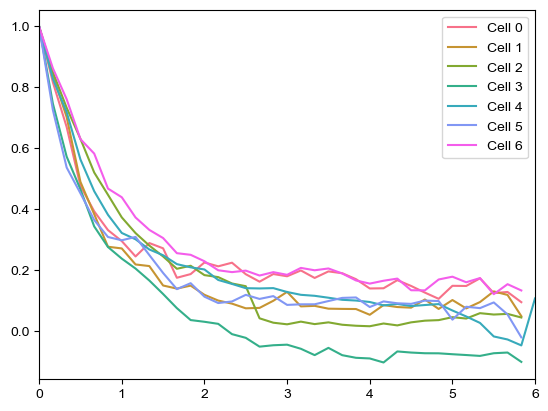

In [14]:
wt_chase_frame = 8
dfs = wt_trace_dfs
y_var = 'Mean_rfp'
norm = True
ax = plt.axes()
ax.set_xlim(0, 6)
colors = sns.color_palette('husl', len(dfs))
for i, df in enumerate(dfs):
    y = df.loc[wt_chase_frame:, y_var] - bg
    x = [(i*10)/60 for i in range(len(y))]
    if norm:
        y = y/y.iloc[0]
    ax.plot(x, y, color=colors[i], label=f'Cell {i}')
ax.legend()

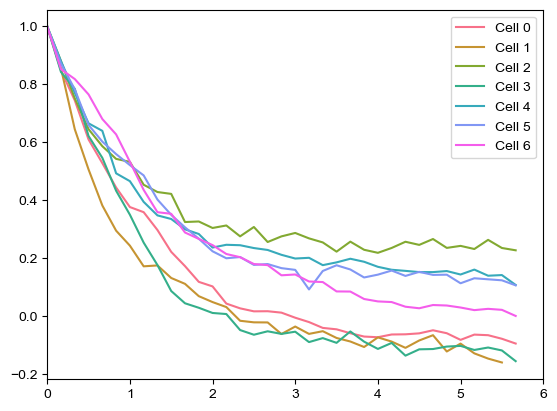

In [20]:
rpn4d_chase_frame = 9
dfs = rpn4d_trace_dfs
y_var = 'Mean_rfp'
norm = True
ax = plt.axes()
ax.set_xlim(0, 6)
colors = sns.color_palette('husl', len(dfs))
for i, df in enumerate(dfs):
    y = df.loc[rpn4d_chase_frame:, y_var] - bg
    x = [(i*10)/60 for i in range(len(y))]
    if norm:
        y = y/y.iloc[0]
    ax.plot(x, y, color=colors[i], label=f'Cell {i}')
ax.legend()

In [342]:
bg

630

plotting BY4741 cell 0
plotting BY4741 cell 1
plotting BY4741 cell 2
plotting BY4741 cell 3
plotting BY4741 cell 4
plotting BY4741 cell 5
plotting BY4741 cell 6
plotting rpn4d cell 0
plotting rpn4d cell 1
plotting rpn4d cell 2
plotting rpn4d cell 3
plotting rpn4d cell 4
plotting rpn4d cell 5
plotting rpn4d cell 6


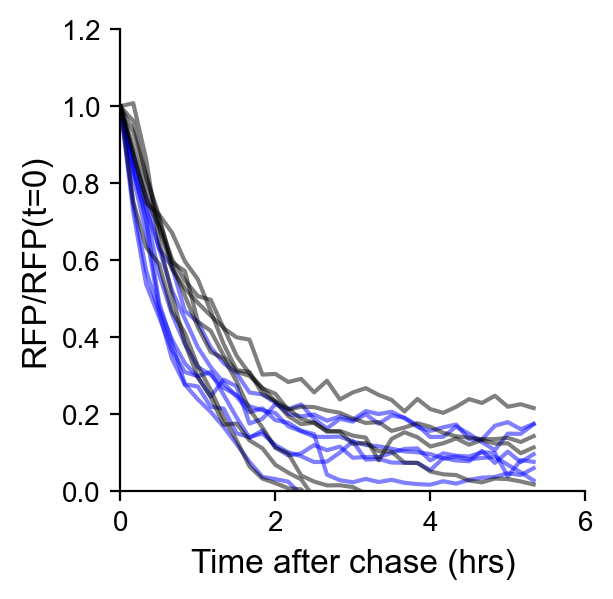

In [16]:
colors = ['blue', 'black']
chase_duration = 33
fig = plt.figure(figsize=(3, 3))
fig.set_dpi(200)
ax = plt.axes()
# Plot WT cells
dfs = wt_trace_dfs
chase_frame = wt_chase_frame
start_frame = chase_frame
delta_t = 10
offset = (start_frame*delta_t)/60

for i, df in enumerate(dfs):
    print(f'plotting BY4741 cell {i}')
    df.loc[:, 'mean_rfp_bg_sub'] = df.Mean_rfp - bg
    df.loc[:, 'norm_rfp'] = df.mean_rfp_bg_sub/df.loc[chase_frame, 'mean_rfp_bg_sub']

    y = df.norm_rfp[start_frame:start_frame + chase_duration]    
    x = np.arange(0, (len(y)*delta_t)/60, delta_t/60)
    ax.plot(x, y,
            color=colors[0], alpha=0.5)
    
# Plot rpn4d cells
dfs = rpn4d_trace_dfs
chase_frame = rpn4d_chase_frame
start_frame = chase_frame
offset = (start_frame*10)/60

for i, df in enumerate(dfs):
    print(f'plotting rpn4d cell {i}')
    df.loc[:, 'mean_rfp_bg_sub'] = df.Mean_rfp - bg
    df.loc[:, 'norm_rfp'] = df.mean_rfp_bg_sub/df.loc[chase_frame, 'mean_rfp_bg_sub']
    
    y = df.norm_rfp[start_frame:start_frame + chase_duration]
    x = np.arange(0, (len(y)*delta_t)/60, delta_t/60)
    ax.plot(x, y,
            color=colors[1], alpha=0.5)
    
ax.set_ylabel('RFP/RFP(t=0)', fontsize=12)
ax.set_xlabel('Time after chase (hrs)', fontsize=12)
ax.set_xlim(0, 6)
ax.set_ylim(0, 1.2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [17]:
reload(ft)

<module 'byc.fitting_tools' from 'C:\\Users\\John Cooper\\Projects\\byc\\byc\\fitting_tools.py'>

fitting wt
fitting rpn4d


[Text(0, 0, 'WT'), Text(0, 0, 'rpn4$\\Delta$')]

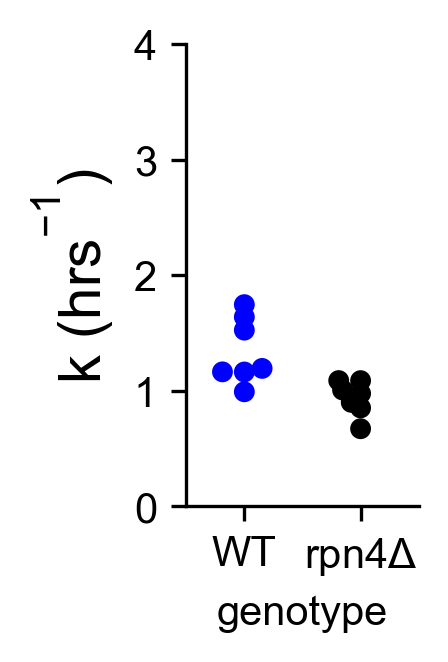

In [22]:
from byc import fitting_tools as ft
print('fitting wt')
wt_fits_df = ft.get_all_fits_df(wt_trace_dfs, wt_chase_frame, wt_chase_frame+chase_duration,
                                col_name='Mean_rfp',
                                background=bg)
print('fitting rpn4d')
rpn4d_fits_df = ft.get_all_fits_df(rpn4d_trace_dfs, rpn4d_chase_frame, rpn4d_chase_frame+chase_duration,
                                   col_name='Mean_rfp',
                                   background=bg)

wt_fits_df.loc[:, 'genotype'] = 'BY4741'
rpn4d_fits_df.loc[:, 'genotype'] = 'rpn4d'
all_fits_df = pd.concat([wt_fits_df, rpn4d_fits_df], ignore_index=True)
all_fits_df.loc[:, 'halflife'] = np.log(2)/all_fits_df.b
all_fits_df.loc[:, "substrate"] = 'UBL-mScarletI-NS'
all_fits_table = pd.pivot_table(all_fits_df, index=['cell_index', 'genotype'], aggfunc=np.mean).reset_index()

palette = sns.color_palette(['blue', 'black'])

fig = plt.figure(figsize=(1, 2))
fig.set_dpi(300)
ax = sns.swarmplot(x='genotype', y='b', data=all_fits_table,
                   palette=palette, order=['BY4741', 'rpn4d'])
ax.set_ylim(0, 4)
# ax.set_yticks(np.arange(0, 2.1, 0.4))
ax.set_ylabel(r'k (hrs$^{-1}$)', fontsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xticklabels(['WT', r'rpn4$\Delta$'])

[Text(0, 0, 'WT'), Text(0, 0, 'rpn4$\\Delta$')]

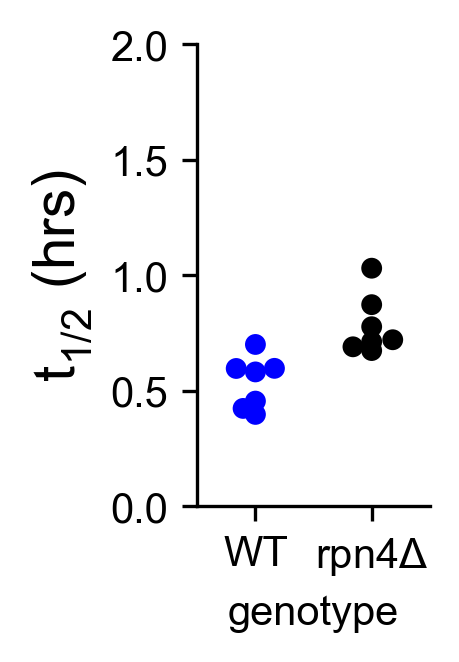

In [19]:
palette = sns.color_palette(['blue', 'black'])

fig = plt.figure(figsize=(1, 2))
fig.set_dpi(300)
ax = sns.swarmplot(x='genotype', y='halflife', data=all_fits_table,
                   palette=palette, order=['BY4741', 'rpn4d'])
ax.set_ylim(0, 2)
ax.set_ylabel(r't$_{1/2}$ (hrs)', fontsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xticklabels(['WT', r'rpn4$\Delta$'])

## Fitting exponential decay curve to estradiol washout data from 20190208_byc

In [1]:
import os
import shutil

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

plt.style.use('default')
matplotlib.rcParams['font.sans-serif'] = 'Arial'

from byc import standard_analysis as sa
from byc import files
import byc.fitting_tools as ft

In [2]:
ubr2d = sa.get_dfs_list()

In [ ]:
for i, df in enumerate(ubr2d):
    

In [3]:
rpn4d = sa.get_dfs_list()

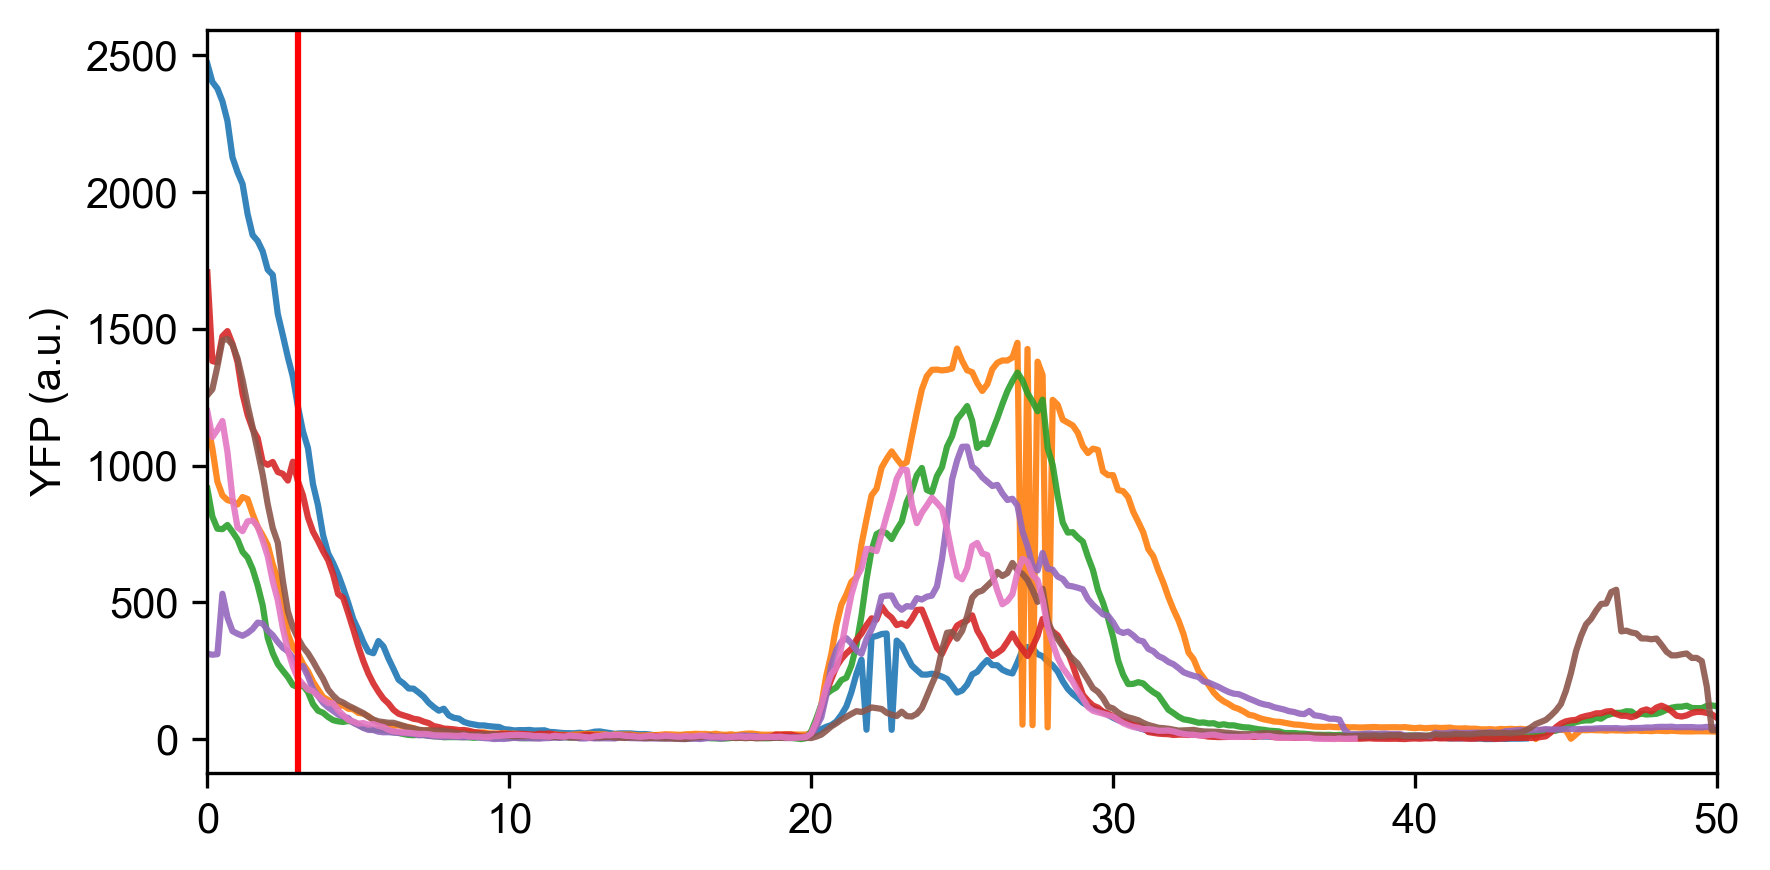

In [4]:
fig = plt.figure(figsize=(6, 3))
fig.set_dpi(300)
ax = fig.add_subplot(111)


for df in rpn4d:
    x_raw = df.hours - 10/60
    y = df.yfp_mean
    y = y - y.min()
    y_norm = y/y.iloc[0]
    ax.plot(x_raw, y, alpha=0.9)
    
# ax.set_ylim(0, 500)
ax.set_ylabel('YFP (a.u.)')
ax.axvline(3, color='red')
ax.set_xlim(0, 50)
plt.tight_layout()

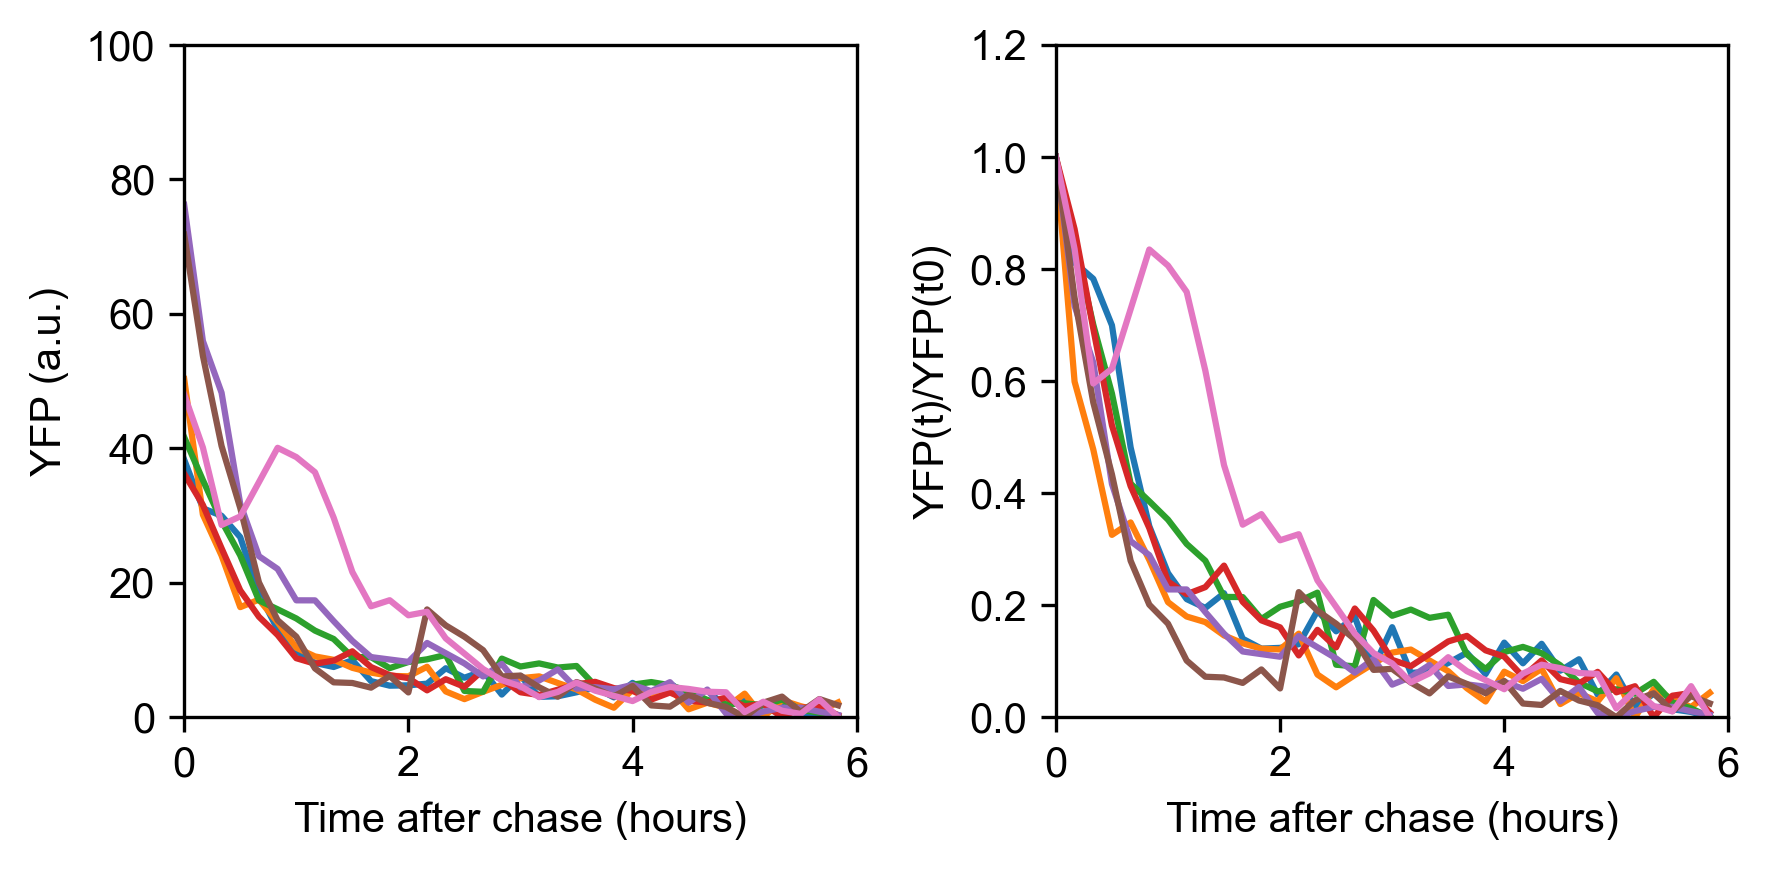

In [5]:
window_width = 36
start_frame = 19
last_frame = start_frame + window_width

fig = plt.figure(figsize=(6, 3))
fig.set_dpi(300)
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)


for df in ubr2d:
    x_raw = df.hours[start_frame:last_frame]
    x = x_raw - start_frame*(10/60) - 10/60
    y = df.yfp_mean[start_frame:last_frame]
    y = y - y.min()
    y_norm = y/y.iloc[0]
    ax.plot(x, y)
    ax2.plot(x, y_norm)
    
ax.set_ylim(0, 100)
ax.set_ylabel('YFP (a.u.)')
ax2.set_ylabel('YFP(t)/YFP(t0)')
ax2.set_ylim(0, 1.2)
for a in [ax, ax2]:
    a.set_xlabel('Time after chase (hours)')
ax.set_xlim(0, 6)
ax2.set_xlim(0, 6)
plt.tight_layout()

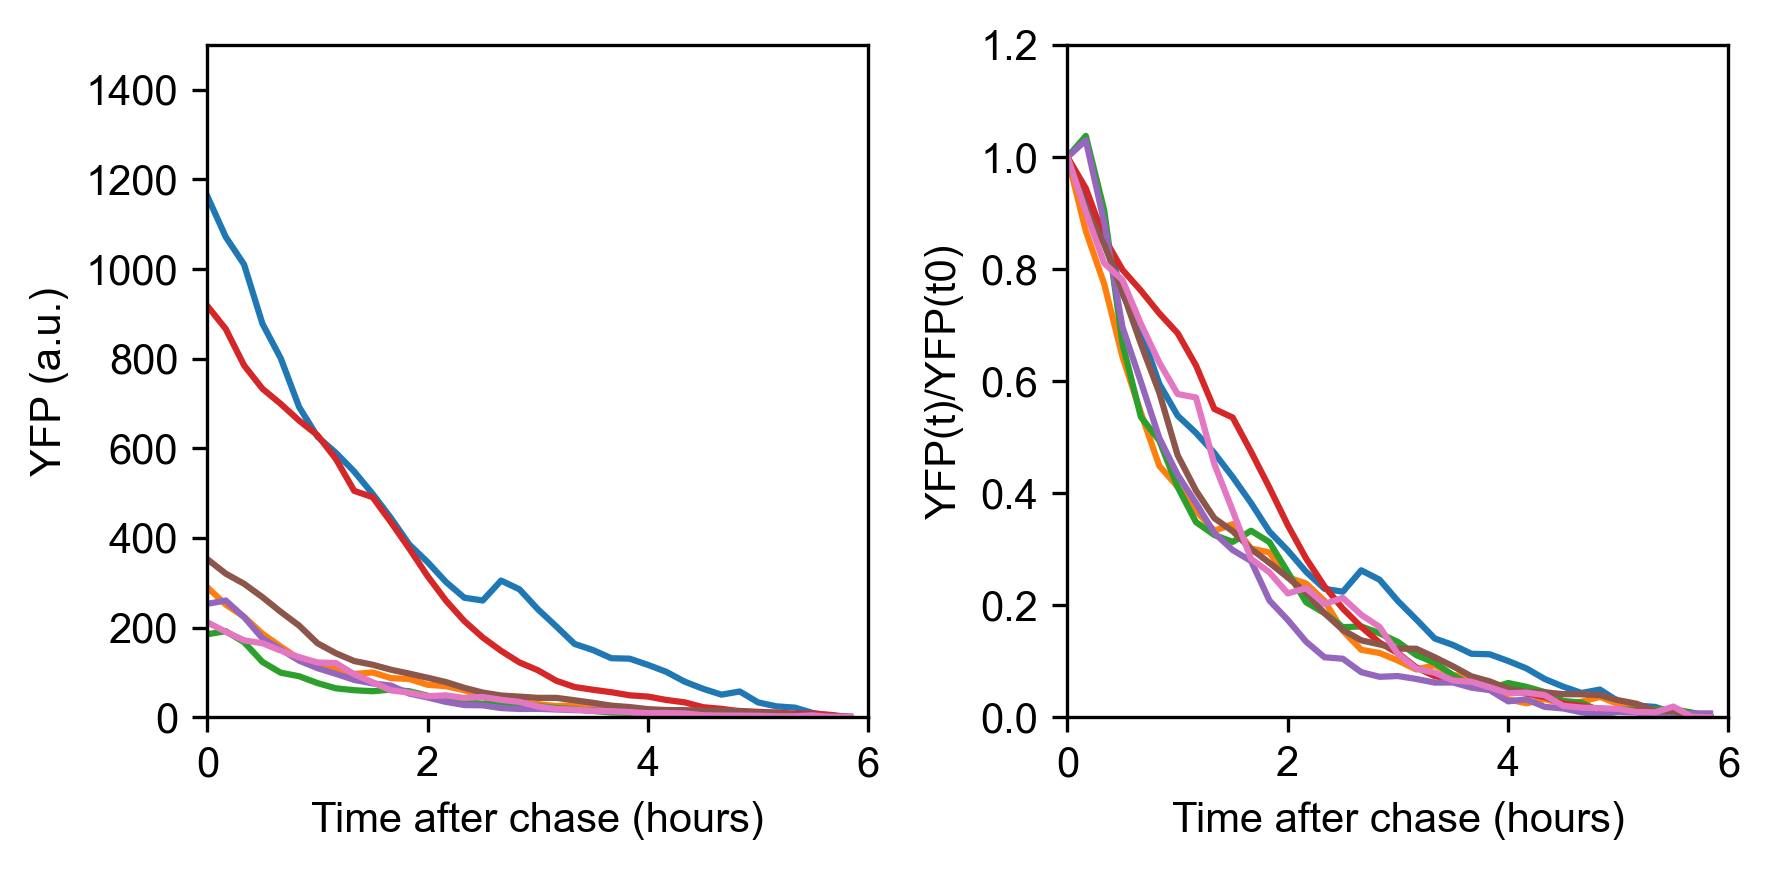

In [6]:
window_width = 36
start_frame = 18
last_frame = start_frame + window_width

fig = plt.figure(figsize=(6, 3))
fig.set_dpi(300)
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)


for df in rpn4d:
    x_raw = df.hours[start_frame:last_frame]
    x = x_raw - start_frame*(10/60) - 10/60
    y = df.yfp_mean[start_frame:last_frame]
    y = y - y.min()
    y_norm = y/y.iloc[0]
    ax.plot(x, y)
    ax2.plot(x, y_norm)
    
ax.set_ylim(0, 1500)
ax.set_ylabel('YFP (a.u.)')
ax2.set_ylabel('YFP(t)/YFP(t0)')
ax2.set_ylim(0, 1.2)
for a in [ax, ax2]:
    a.set_xlabel('Time after chase (hours)')
ax.set_xlim(0, 6)
ax2.set_xlim(0, 6)
plt.tight_layout()

In [80]:
rpn4d_fits_df = ft.get_all_fits_df(rpn4d, 18, 18+36,
                                col_name='yfp_mean')
rpn4d_fits_df.loc[:, 'deletion'] = 'rpn4'
ubr2d_fits_df = ft.get_all_fits_df(ubr2d, 18, 18+36,
                                col_name='yfp_mean')
ubr2d_fits_df.loc[:, 'deletion'] = 'ubr2'

all_fits_df = pd.concat([rpn4d_fits_df, ubr2d_fits_df], ignore_index=True)

In [120]:
aggdf = all_fits_df.pivot_table(index=['cell_index', 'deletion']).reset_index()

In [122]:
all_fits_df

,cell_index,age_at_chase,rls,div_duration,dist_from_sen,late_daughter_shape,x_input,y_input_raw,y_input_norm,y_pred_norm,residual,r_sq,est_std_err,shapiro_p,a,b,c,deletion
0,NaN,NaN,NaN,NaN,NaN,NaN,0.166667,1194.849,1.000000,1.000022,-0.000022,0.996135,0.016489,0.000026,1.102119,0.536805,-0.007775,rpn4
1,NaN,NaN,NaN,NaN,NaN,NaN,0.333333,1104.129,0.924074,0.913773,0.010301,0.996135,0.016489,0.000026,1.102119,0.536805,-0.007775,rpn4
2,NaN,NaN,NaN,NaN,NaN,NaN,0.500000,1042.558,0.872544,0.834905,0.037639,0.996135,0.016489,0.000026,1.102119,0.536805,-0.007775,rpn4
3,NaN,NaN,NaN,NaN,NaN,NaN,0.666667,910.493,0.762015,0.762787,-0.000771,0.996135,0.016489,0.000026,1.102119,0.536805,-0.007775,rpn4
4,NaN,NaN,NaN,NaN,NaN,NaN,0.833333,832.941,0.697110,0.696840,0.000270,0.996135,0.016489,0.000026,1.102119,0.536805,-0.007775,rpn4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
765,NaN,NaN,NaN,NaN,NaN,NaN,8.500000,4.379,0.074733,0.024690,0.050044,0.929613,0.066329,0.000289,1.020299,0.573514,0.016899,ubr2
766,NaN,NaN,NaN,NaN,NaN,NaN,8.666667,4.097,0.069921,0.023979,0.045941,0.929613,0.066329,0.000289,1.020299,0.573514,0.016899,ubr2
767,NaN,NaN,NaN,NaN,NaN,NaN,8.833333,5.550,0.094718,0.023334,0.071384,0.929613,0.066329,0.000289,1.020299,0.573514,0.016899,ubr2
768,NaN,NaN,NaN,NaN,NaN,NaN,9.000000,3.369,0.057496,0.022747,0.034749,0.929613,0.066329,0.000289,1.020299,0.573514,0.016899,ubr2


# 20210903 JPC096 NLS-YFP-ODC(47)x3 in BY4741 old chase

In [2]:
import os
import shutil

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

plt.style.use('default')
matplotlib.rcParams['font.sans-serif'] = 'Arial'
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

from byc import standard_analysis as sa
from byc import files
import byc.fitting_tools as ft

### 1. Create master df from .csvs generated by running the Fiji plugin `imagejpc/save cell roi set` and selecting entering 'crop' as roi type

In [93]:
import os
import re

import pandas as pd

from byc import constants
from byc import files
from byc import standard_analysis as sa

from importlib import reload
reload(constants)
reload(files)

exptname = '20210903_byc'
compartmentname = '20210903_JPC096_NLS-YFP-ODC(47)x3_BY4741_old_chase'
mdf_type = 'crop_rois'
file_pattern = constants.patterns.crop_roi_df_file
compartmentdir = files.get_byc_compartmentdir(exptname, compartmentname)
print(f'Found compartment directory:\n{compartmentdir}')
mdf = files.mdf_from_file_pattern(compartmentdir, file_pattern, mdf_type=mdf_type)

Found compartment directory:
C:\Users\John Cooper\Projects\byc\data\20210903_byc\20210903_JPC096_NLS-YFP-ODC(47)x3_BY4741_old_chase
Saved master index df at:
C:\Users\John Cooper\Projects\byc\data\20210903_byc\20210903_JPC096_NLS-YFP-ODC(47)x3_BY4741_old_chase_crop_rois.csv


### 2. After creating master index, run `byc/bin/run_segmentation` and when prompted select the master index file created above

### 3. Use Fiji to curate cell outlines created in `run_segmentation`

    A.) Open the cropped cell stacks (all channels as well as the otsu_thresholded one)
    B.) Make the otsu thresholded stack the active image. Press 'g' to convert the stack to a mask (cell area should be black after this).
    C.) Press '8' to run a watershed on the stack (find edges between overlapping/adjacent blobs)
    D.) Press 'q' to set measurements. Choose desired measurements (more the better). Choose None for redirect image
    E.) Press 'u' to run 'Analyze Particles'. At 60x, set Size range to 100-1000 square pixels and circularity to 0.8-1. Check 'Add to manager' and 'Exclude on edges. 'Click 'OK'
    F.) In ROI manager, delete or redraw bad ROIs. Add new ones so that there are at least one for the first and last frames and a every 10-20 frames, then run `imagejpc/save cell roi set` and select 'measurement' as ROI type

### 4. To quantify cell fluorescence traces using the ROIs above, , run `imagejpc/measure rois` with the cell's cropped channel stacks and measurement_rois.zip files open

### 5. Read in traces

In [92]:
ds = sa.bycDataSet(mdf=mdf)

Found 0 channel dfs
No data found for cell with pattern: (20210903_byc_xy00_cell000)_(.+)_(stack.csv)
Base filename: 20210903_byc_xy00_cell000
Checked compartment dir: C:\Users\John Cooper\Projects\byc\data\20210903_byc\20210903_JPC096_NLS-YFP-ODC(47)x3_BY4741_old_chase
Found 0 channel dfs
No data found for cell with pattern: (20210903_byc_xy00_cell001)_(.+)_(stack.csv)
Base filename: 20210903_byc_xy00_cell001
Checked compartment dir: C:\Users\John Cooper\Projects\byc\data\20210903_byc\20210903_JPC096_NLS-YFP-ODC(47)x3_BY4741_old_chase
Found 0 channel dfs
No data found for cell with pattern: (20210903_byc_xy00_cell002)_(.+)_(stack.csv)
Base filename: 20210903_byc_xy00_cell002
Checked compartment dir: C:\Users\John Cooper\Projects\byc\data\20210903_byc\20210903_JPC096_NLS-YFP-ODC(47)x3_BY4741_old_chase
Found 0 channel dfs
No data found for cell with pattern: (20210903_byc_xy01_cell003)_(.+)_(stack.csv)
Base filename: 20210903_byc_xy01_cell003
Checked compartment dir: C:\Users\John Coope

In [11]:
y_var = 'Mean_rfp'
for df in wt_trace_dfs:
    bg = df.loc[:, y_var].min()
    print(bg)
    y = df.loc[:, y_var] - df.loc[:, y_var].min()
    x = [(i*10)/60 for i in range(len(y))]

694.3
680.941
680.0260000000001
636.964
634.178
667.154
702.15


In [13]:
y_var = 'Mean_rfp'
for df in rpn4d_trace_dfs:
    bg = df.loc[:, y_var].min()
    print(bg)
    y = df.loc[:, y_var] - df.loc[:, y_var].min()
    x = [(i*10)/60 for i in range(len(y))]

630.472
648.906
729.721
639.9780000000001
712.193
702.573
671.087


In [299]:
bg = 630

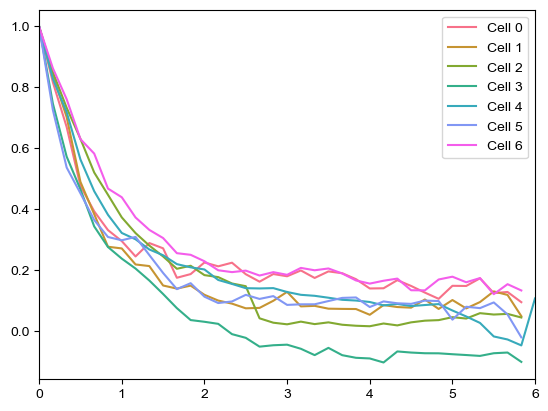

In [14]:
wt_chase_frame = 8
dfs = wt_trace_dfs
y_var = 'Mean_rfp'
norm = True
ax = plt.axes()
ax.set_xlim(0, 6)
colors = sns.color_palette('husl', len(dfs))
for i, df in enumerate(dfs):
    y = df.loc[wt_chase_frame:, y_var] - bg
    x = [(i*10)/60 for i in range(len(y))]
    if norm:
        y = y/y.iloc[0]
    ax.plot(x, y, color=colors[i], label=f'Cell {i}')
ax.legend()

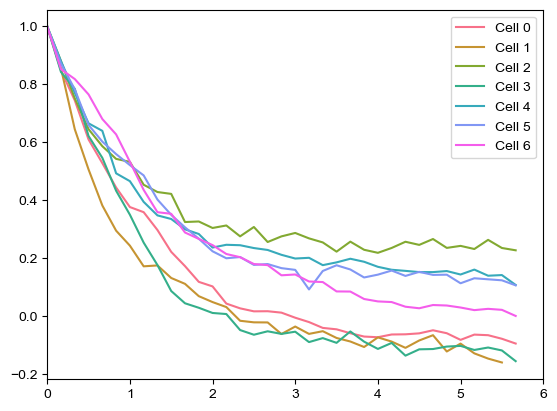

In [20]:
rpn4d_chase_frame = 9
dfs = rpn4d_trace_dfs
y_var = 'Mean_rfp'
norm = True
ax = plt.axes()
ax.set_xlim(0, 6)
colors = sns.color_palette('husl', len(dfs))
for i, df in enumerate(dfs):
    y = df.loc[rpn4d_chase_frame:, y_var] - bg
    x = [(i*10)/60 for i in range(len(y))]
    if norm:
        y = y/y.iloc[0]
    ax.plot(x, y, color=colors[i], label=f'Cell {i}')
ax.legend()

In [342]:
bg

630

plotting BY4741 cell 0
plotting BY4741 cell 1
plotting BY4741 cell 2
plotting BY4741 cell 3
plotting BY4741 cell 4
plotting BY4741 cell 5
plotting BY4741 cell 6
plotting rpn4d cell 0
plotting rpn4d cell 1
plotting rpn4d cell 2
plotting rpn4d cell 3
plotting rpn4d cell 4
plotting rpn4d cell 5
plotting rpn4d cell 6


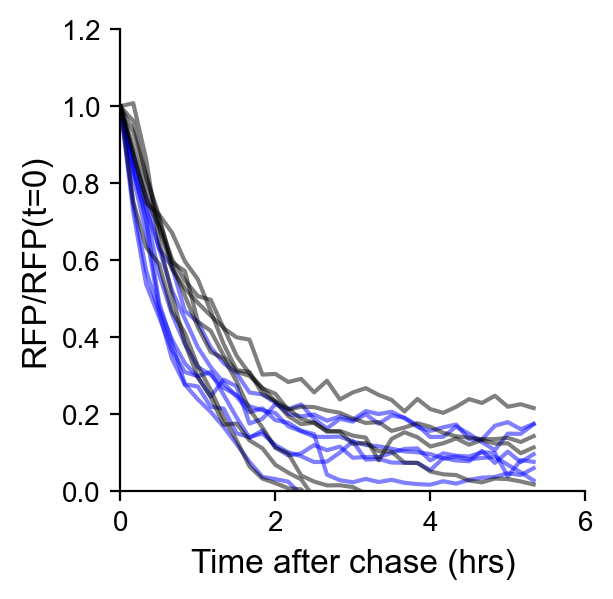

In [16]:
colors = ['blue', 'black']
chase_duration = 33
fig = plt.figure(figsize=(3, 3))
fig.set_dpi(200)
ax = plt.axes()
# Plot WT cells
dfs = wt_trace_dfs
chase_frame = wt_chase_frame
start_frame = chase_frame
delta_t = 10
offset = (start_frame*delta_t)/60

for i, df in enumerate(dfs):
    print(f'plotting BY4741 cell {i}')
    df.loc[:, 'mean_rfp_bg_sub'] = df.Mean_rfp - bg
    df.loc[:, 'norm_rfp'] = df.mean_rfp_bg_sub/df.loc[chase_frame, 'mean_rfp_bg_sub']

    y = df.norm_rfp[start_frame:start_frame + chase_duration]    
    x = np.arange(0, (len(y)*delta_t)/60, delta_t/60)
    ax.plot(x, y,
            color=colors[0], alpha=0.5)
    
# Plot rpn4d cells
dfs = rpn4d_trace_dfs
chase_frame = rpn4d_chase_frame
start_frame = chase_frame
offset = (start_frame*10)/60

for i, df in enumerate(dfs):
    print(f'plotting rpn4d cell {i}')
    df.loc[:, 'mean_rfp_bg_sub'] = df.Mean_rfp - bg
    df.loc[:, 'norm_rfp'] = df.mean_rfp_bg_sub/df.loc[chase_frame, 'mean_rfp_bg_sub']
    
    y = df.norm_rfp[start_frame:start_frame + chase_duration]
    x = np.arange(0, (len(y)*delta_t)/60, delta_t/60)
    ax.plot(x, y,
            color=colors[1], alpha=0.5)
    
ax.set_ylabel('RFP/RFP(t=0)', fontsize=12)
ax.set_xlabel('Time after chase (hrs)', fontsize=12)
ax.set_xlim(0, 6)
ax.set_ylim(0, 1.2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)